# Results Interpretation

In [9]:
# import all required modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.inspection import permutation_importance
from numpy.lib.shape_base import row_stack
import pickle

In [10]:
# connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# define a function that saves figures
def save_fig(fig_id, tight_layout=True):
    # The path of the figures folder ./Figures/fig_id.png (fig_id is a variable that you specify 
    # when you call the function)
    path = os.path.join(fig_id + ".png") 
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [12]:
def abs_mean_plot(weight_df, path):
  # sort values by absolute mean
  weight_df.weight = weight_df.weight/len(weights)
  weight_df.weight = weight_df.weight/max(weight_df.weight)*100
  abs_mean = weight_df.sort_values('weight', ascending = False).head(30)

  #Plot abs mean
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,15))

  y_ticks = range(len(abs_mean))
  y_labels = abs_mean.word
  plt.barh(y=y_ticks,width=abs_mean.weight)

  plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
  plt.title('LIME Weights - Average Absolute Values of Test Set Explanations')
  plt.ylabel('')
  plt.xlabel('Mean |Weight|',size=20)

  
  save_fig(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/{path}')

  plt.show()

## Text Only Results

### No Preprocessing

#### LIME

In [ ]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
lemmatization = False # set to True if we want to lemmatize
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_labels{preproc_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [ ]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

775175


37119

In [ ]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only


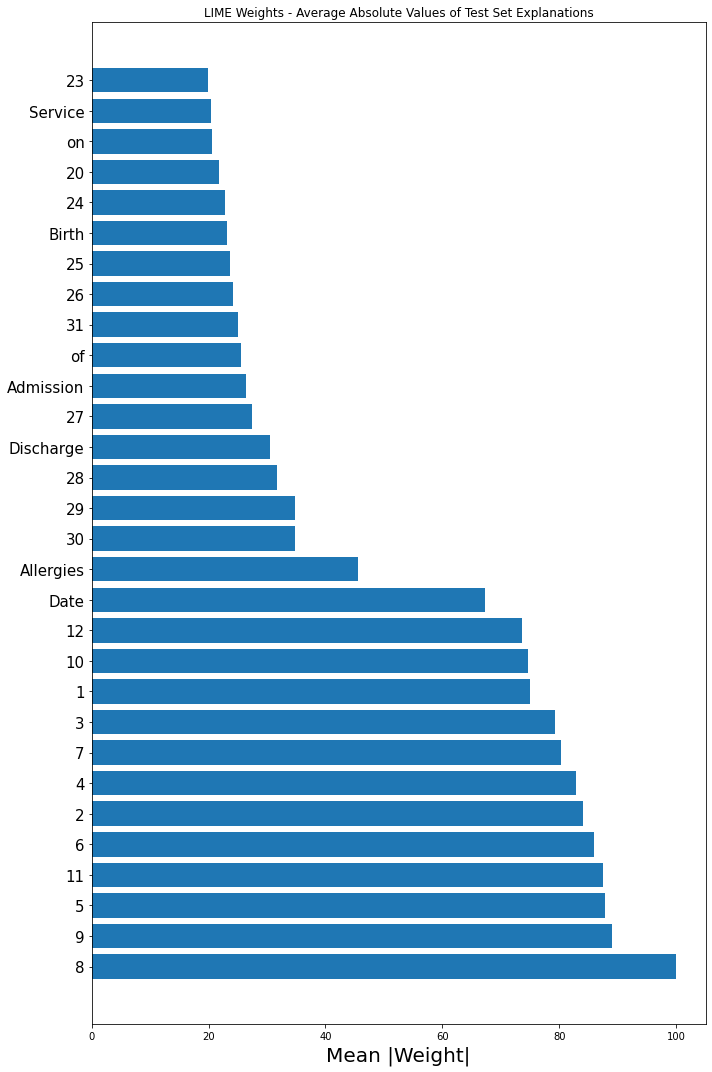

In [ ]:
abs_mean_plot(weight_df, 'text_only')

#### LIME - Condense Dates

In [ ]:
# import dataset
file = '/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_mixed_discharge.csv'
raw_df = pd.read_csv(file, low_memory=False)

In [ ]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['Unnamed: 0', 'HADM_ID', 'subject_id','icu_los'])

In [ ]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(39841, 39105)

In [ ]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])

In [ ]:
# drop variables having more than 20 % missing values
df = df.drop(columns=['albumin_min','patientweight','type_stay'])

In [ ]:
# save df
df_copy = df.copy()

In [ ]:
# impute missing values
df = df_copy.interpolate()

In [ ]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.142, Third Quartile = 14.506, Interquartile Interval = 9.365
Lower Fence = -8.905, Upper Fence = 28.553


In [ ]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF

In [ ]:
# restrict to just discharge notes
df = df[['los_cat', 'discharge']]

In [ ]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

In [ ]:
df_test['weights'] = weights
df_test['labels'] = labels

In [ ]:
import re

In [ ]:
def extract_adm(text):
  date = re.search(r'Admission Date:\s+\[\*\*(.+?)\*\*\]', text, flags = re.IGNORECASE)
  try:
    date = date.group(0)
  except:
    date = 'Missing'
  return date

def extract_disch(text):
  date = re.search(r'Discharge Date:\s+\[\*\*(.+?)\*\*\]', text, flags = re.IGNORECASE)
  try:
    date = date.group(0)
  except:
    date = 'Missing'
  return date

In [ ]:
df_test['admission_date'] = df_test.discharge.apply(lambda x: extract_adm(x))
df_test['discharge_date'] = df_test.discharge.apply(lambda x: extract_disch(x))

In [ ]:
df_test.shape

(7821, 6)

In [ ]:
df_test_clean = df_test.loc[df_test.admission_date != 'Missing']

In [ ]:
df_test_clean.shape

(7804, 6)

In [ ]:
df_test_clean = df_test_clean.loc[df_test_clean.discharge_date != 'Missing']
df_test_clean.shape

(7727, 6)

In [ ]:
def clean_date(text):
  text = re.sub(r'(Admission|Discharge) Date:\s+\[\*\*', "", text)
  text = re.sub(r'\*\*\]', '', text)
  return text

In [ ]:
df_test_clean['admission_date'] = df_test_clean.admission_date.apply(lambda x: clean_date(x))
df_test_clean['discharge_date'] = df_test_clean.discharge_date.apply(lambda x: clean_date(x))

In [ ]:
def check_if_dates(x):
  label_clean = []
  for i in x['labels']:
    if bool(re.search(i, x["admission_date"])) or bool(re.search(i, x["admission_date"])):
      label_clean.append('date_placeholder')
    else:
      label_clean.append(i)
  return label_clean

In [ ]:
df_test_clean['label_clean'] = df_test_clean.apply(lambda x: check_if_dates(x), axis = 1)

In [ ]:
df_test_clean.reset_index(inplace = True, drop = True)

In [ ]:
labels_clean = df_test_clean.label_clean.tolist()
weights_clean = df_test_clean.weights.tolist()

In [ ]:
words = [word for single_list in labels_clean for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

765878


36930

In [ ]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights_clean):
  for i, weight in enumerate(single_list):
    dict_of_words[labels_clean[count][i]] += abs(weight)

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_dates_condensed


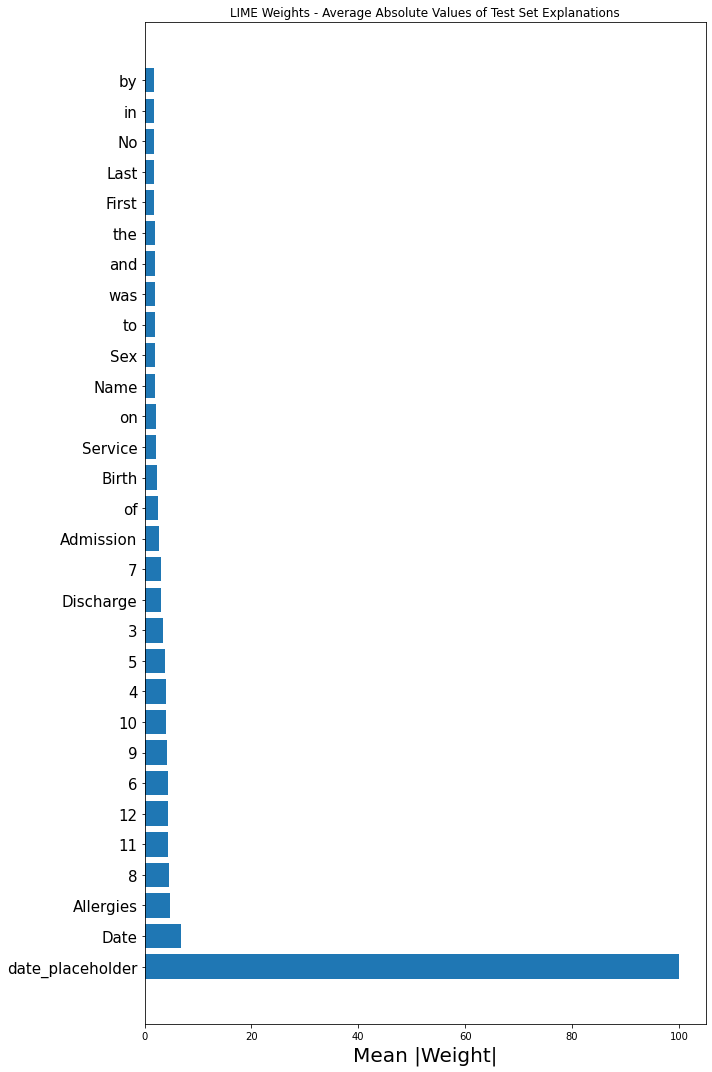

In [ ]:
abs_mean_plot(weight_df, 'text_only_dates_condensed')

#### Transformer Interpret

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights_transformer_interpret{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')

Weights loaded
7831


In [ ]:
weights_flat = [single_list for list_of_lists in weights for single_list in list_of_lists]

In [ ]:
word_list = [x[0] for single_list in weights_flat for x in single_list]
print(len(word_list))
word_list = list(set(word_list)) # get unique values
len(word_list)

3975400


10838

In [ ]:
dict_of_words = {i:0 for i in word_list}

In [ ]:
len(weights_flat)

30814

In [ ]:
for count, single_list in enumerate(weights_flat):
  for i, weight in enumerate(single_list):
    dict_of_words[weight[0]] += abs(weight[1])

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_transformer_int


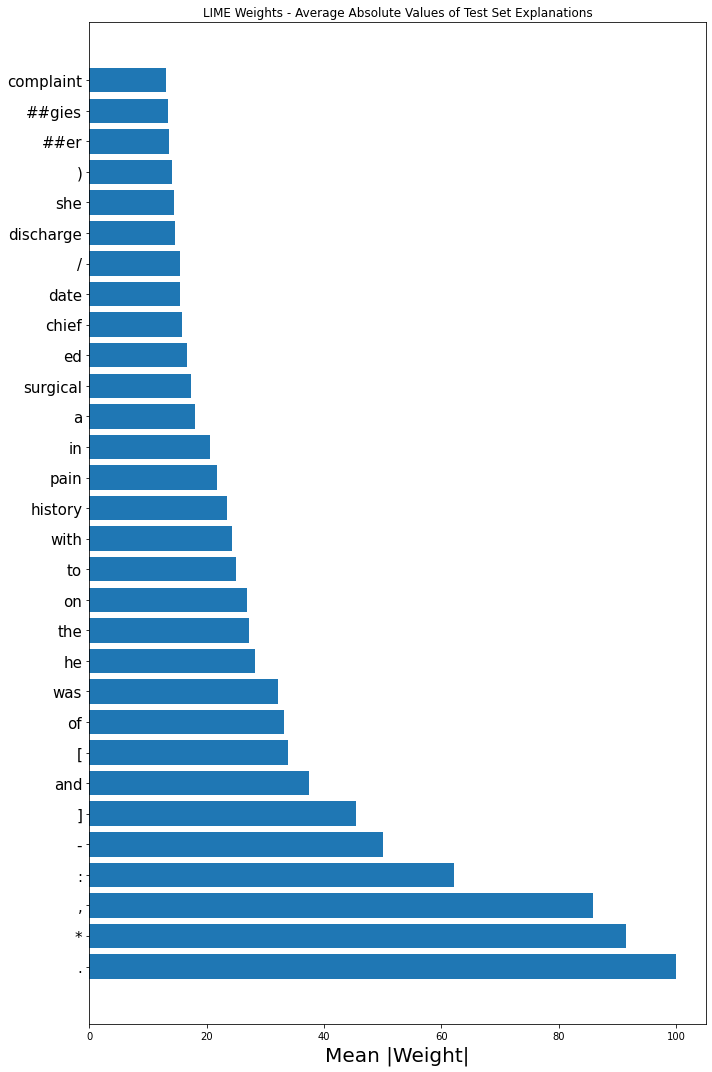

In [ ]:
abs_mean_plot(weight_df, 'text_only_transformer_int')

### Light Preprocessing

#### LIME

In [ ]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
lemmatization = False # set to True if we want to lemmatize
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_labels{preproc_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [ ]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

762605


32378

In [ ]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_light


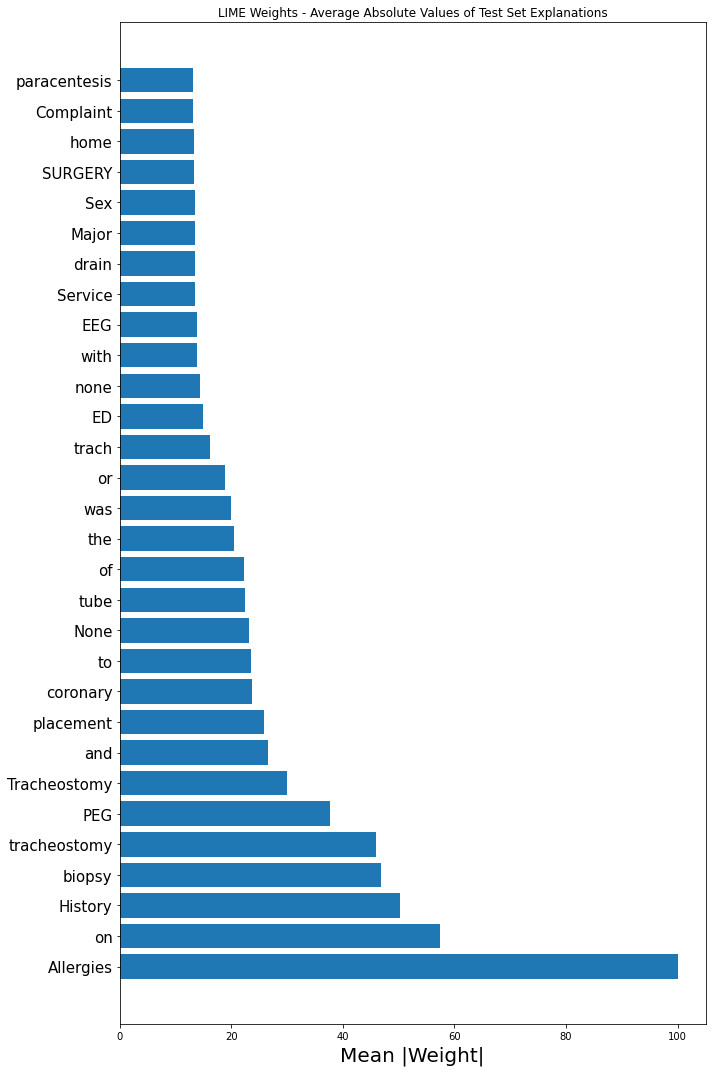

In [ ]:
abs_mean_plot(weight_df, 'text_only_light')

#### Transformer Interpret

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights_transformer_interpret{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')

Weights loaded
7821


In [ ]:
weights_flat = [single_list for list_of_lists in weights for single_list in list_of_lists]

In [ ]:
word_list = [x[0] for single_list in weights_flat for x in single_list]
print(len(word_list))
word_list = list(set(word_list)) # get unique values
len(word_list)

3866420


11123

In [ ]:
dict_of_words = {i:0 for i in word_list}

In [ ]:
len(weights_flat)

30009

In [ ]:
for count, single_list in enumerate(weights_flat):
  for i, weight in enumerate(single_list):
    dict_of_words[weight[0]] += abs(weight[1])

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_light_transformer_int


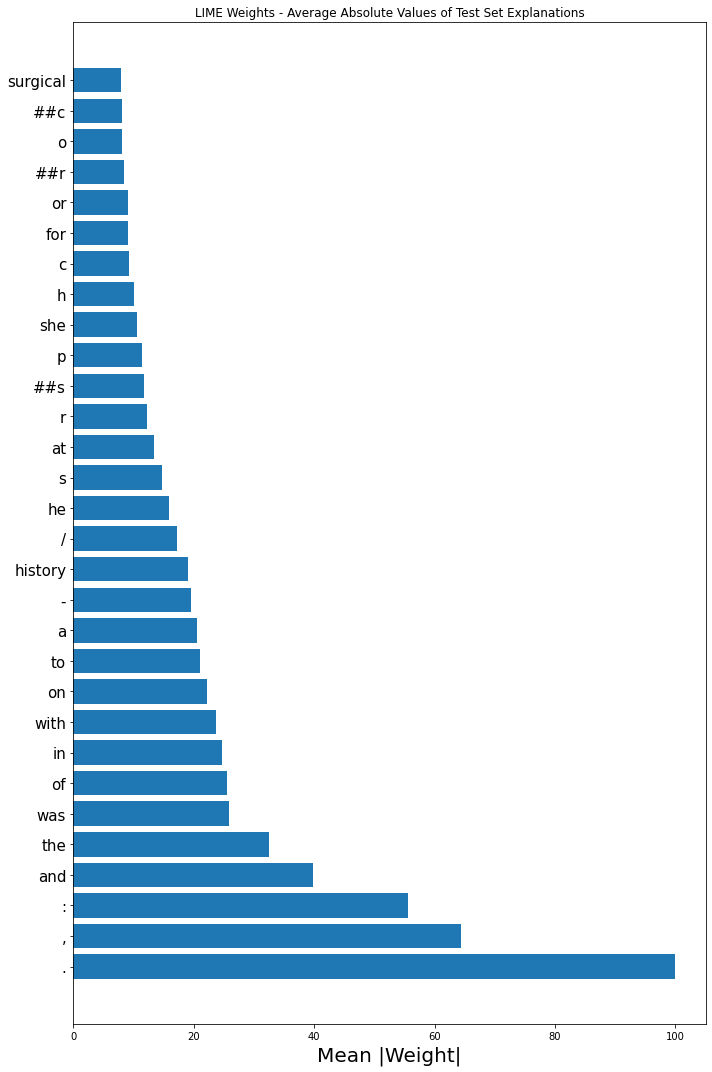

In [ ]:
abs_mean_plot(weight_df, 'text_only_light_transformer_int')

### Heavy Preprocessing

#### LIME

In [13]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
lemmatization = False # set to True if we want to lemmatize
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)

In [14]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_labels{preproc_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [15]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

753510


39524

In [16]:
dict_of_words = {i:0 for i in words}

In [17]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [18]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_heavy


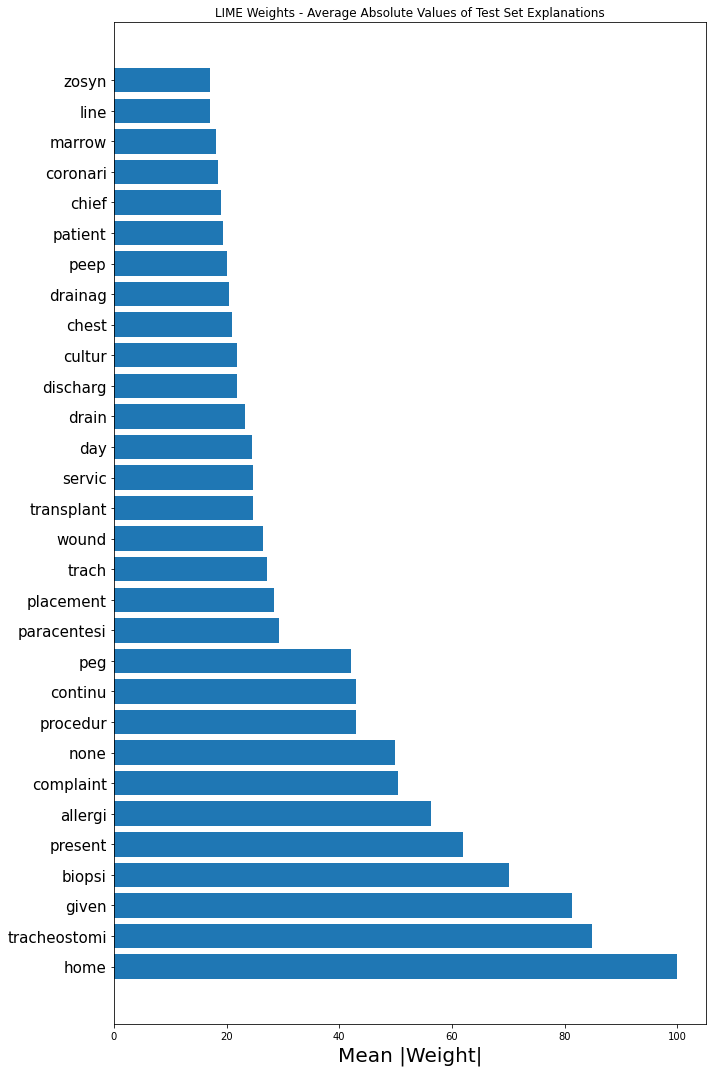

In [19]:
abs_mean_plot(weight_df, 'text_only_heavy')

#### Transformer Interpret

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights_transformer_interpret{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')

Weights loaded
7821


In [ ]:
weights_flat = [single_list for list_of_lists in weights for single_list in list_of_lists]

In [ ]:
word_list = [x[0] for single_list in weights_flat for x in single_list]
print(len(word_list))
word_list = list(set(word_list)) # get unique values
len(word_list)

3849008


7363

In [ ]:
dict_of_words = {i:0 for i in word_list}

In [ ]:
len(weights_flat)

29841

In [ ]:
for count, single_list in enumerate(weights_flat):
  for i, weight in enumerate(single_list):
    dict_of_words[weight[0]] += abs(weight[1])

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_heavy_transformer_int


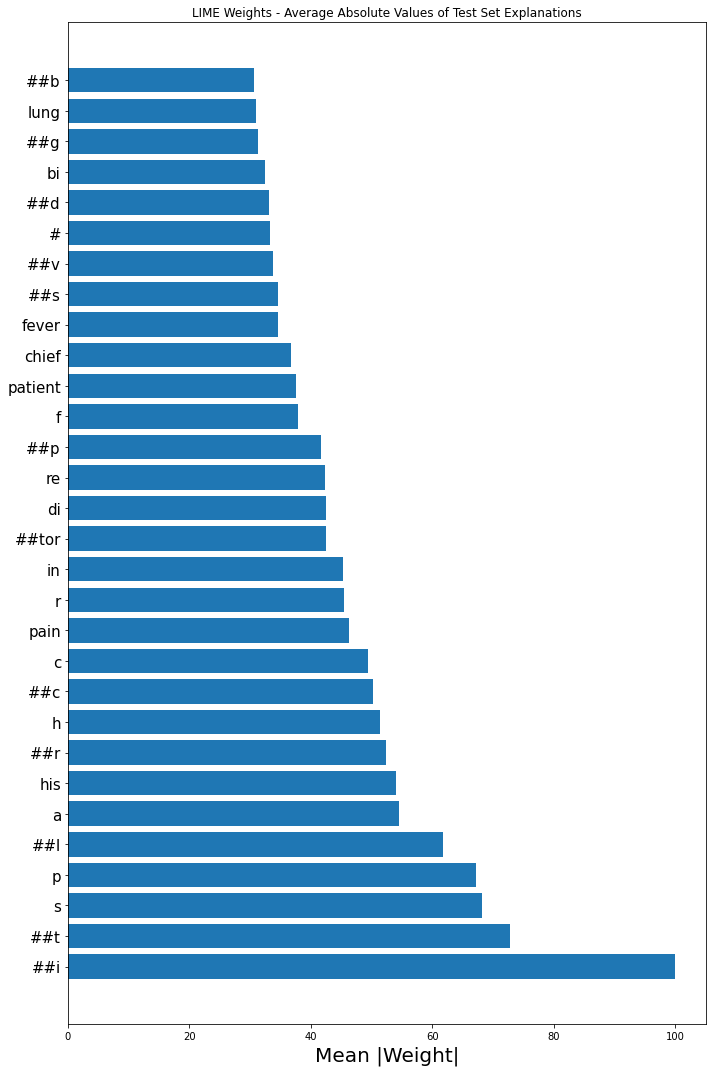

In [ ]:
abs_mean_plot(weight_df, 'text_only_heavy_transformer_int')

### Heavy Preprocessing Lemma

#### LIME

In [ ]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
lemmatization = True # set to True if we want to lemmatize
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_labels{preproc_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [ ]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

753806


42366

In [ ]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_heavy_lemma


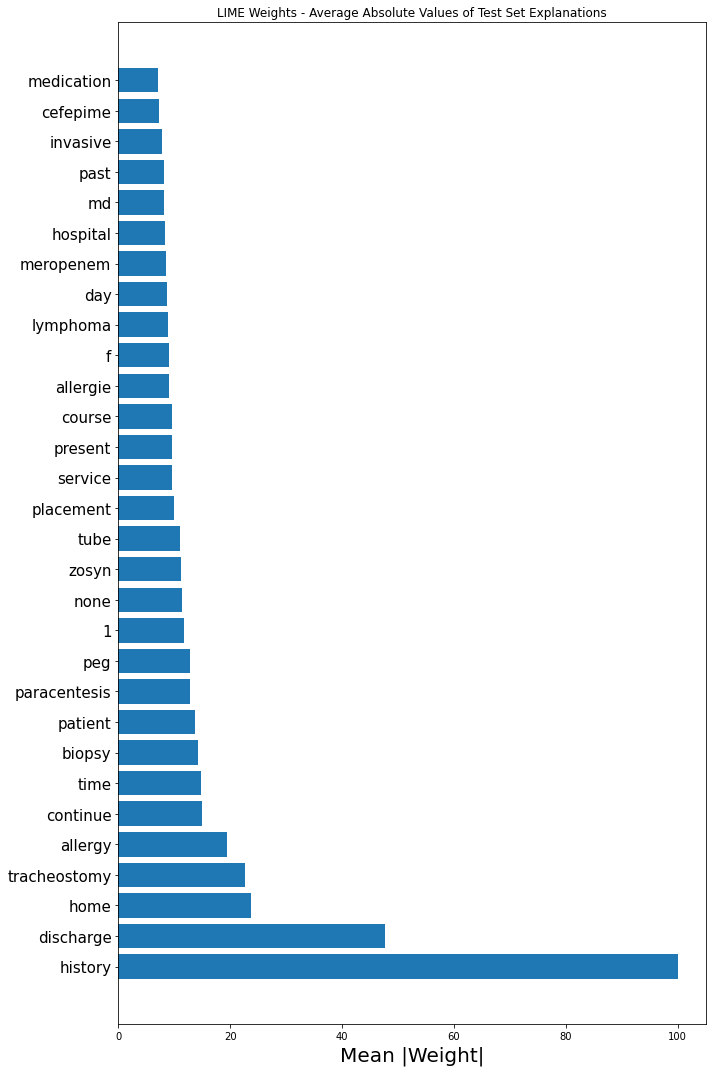

In [ ]:
abs_mean_plot(weight_df, 'text_only_heavy_lemma')

#### Transformer Interpret

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/text_only_weights_transformer_interpret{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')

Weights loaded
4800


In [ ]:
weights_flat = [single_list for list_of_lists in weights for single_list in list_of_lists]

In [ ]:
word_list = [x[0] for single_list in weights_flat for x in single_list]
print(len(word_list))
word_list = list(set(word_list)) # get unique values
len(word_list)

2334806


9353

In [ ]:
dict_of_words = {i:0 for i in word_list}

In [ ]:
len(weights_flat)

18182

In [ ]:
for count, single_list in enumerate(weights_flat):
  for i, weight in enumerate(single_list):
    dict_of_words[weight[0]] += abs(weight[1])

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_only_heavy_lemma_transformer_int


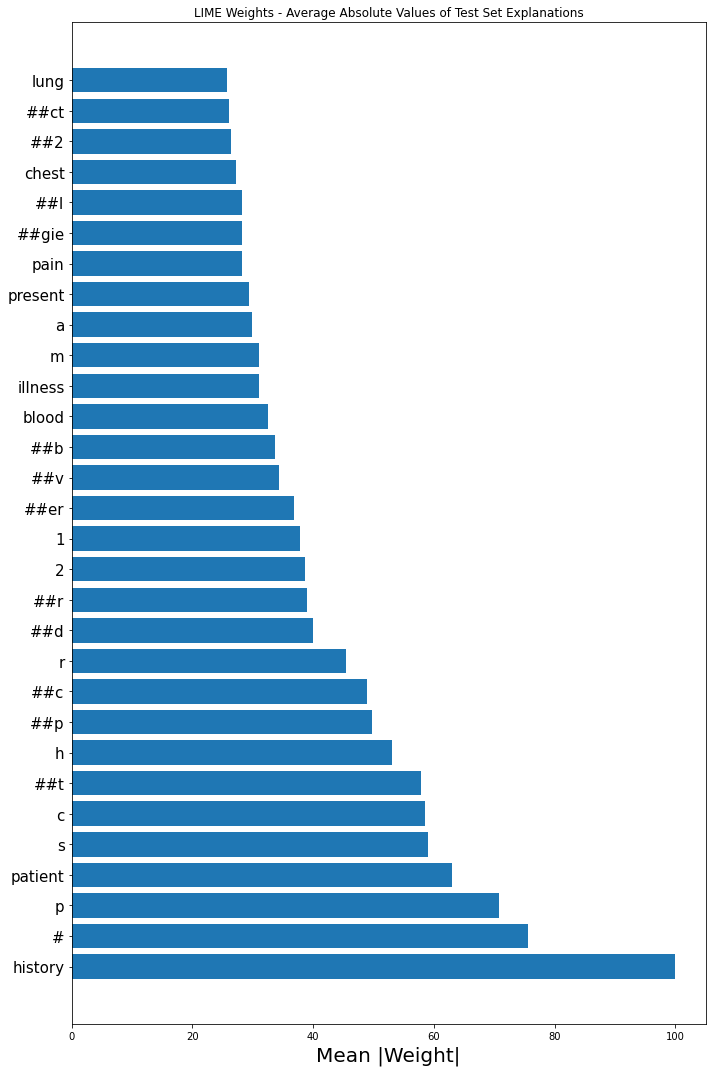

In [ ]:
abs_mean_plot(weight_df, 'text_only_heavy_lemma_transformer_int')

## LIME - KWIC

In [ ]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/weights{preproc_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/labels{preproc_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

New Weight List
New Label List


In [ ]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

0


0

In [ ]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [ ]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

In [ ]:
# sort values by absolute mean
abs_mean = weight_df.sort_values('weight', ascending = False).head(30)
abs_mean.weight = abs_mean.weight/len(weights)

In [ ]:
# Import dataset
df = pd.read_feather(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_los{preproc_tag}')
# restrict to just discharge notes
df = df[['los_cat', 'discharge']]
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)
df_train.shape, df_test.shape

((31284, 2), (7821, 2))

In [ ]:
abs_mean

,word,weight


In [ ]:
!pip install textacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 200 kB 5.1 MB/s 
     |████████████████████████████████| 481 kB 65.2 MB/s 
     |████████████████████████████████| 2.0 MB 81.2 MB/s 
     |████████████████████████████████| 132 kB 84.5 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1236729 sha256=751aed9a73aa8caf786f5eea8491539c7578490388242ed3e29db93c1f60f486
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=74014 sha256=d39a9c7ac6062e8675ebc0ef3ca04297718096e0bd1a5ef699ecf8139d886fb6
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built cytoolz jellyfish


In [ ]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [ ]:
import random
import re

In [ ]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [ ]:
df_test.columns

Index(['los_cat', 'discharge'], dtype='object')

In [ ]:
from tqdm import tqdm

tqdm.pandas()  # <- added this line

In [ ]:
kwic(df_test['discharge'], 'given', print_samples=5)

100%|██████████| 7821/7821 [00:00<00:00, 11481.03it/s]

5 random samples out of 22 contexts for 'given':
ace dc captopril lisinlasix diamox   given  dc foley kefzol cellulitis dc kefzo
 cefipime vancomycin levoquin also   given  a total 15 l ns transfer micu arriv
 prednisone use stressdose steroid   given  in setting shock prednisone use hom
ra gen wdwn comfortable nad sedated  given   fentanyl recently fxs heent pupil 
pon discharge continue phoslo meal   given  n continue elevated phosphate dm ho


In [ ]:
kwic_list_test = kwic(df_test['discharge'], 'given', print_samples=None)

100%|██████████| 7821/7821 [00:00<00:00, 11673.81it/s]


In [ ]:
len(kwic_list_test)

22

In [ ]:
kwic_df = pd.DataFrame(kwic_list_test, columns = ['pre', 'kw', 'post'])

In [ ]:
kwic_df.head()

,pre,kw,post
0,prednisone use stressdose steroid,given,in setting shock prednisone use hom
1,ace dc captopril lisinlasix diamox,given,dc foley kefzol cellulitis dc kefzo
2,e myeloma phenomenon isotype switch,given,increase number virus encode rna p
3,ylenol 1 gm potassium 60 meq fluid,given,500 cc ns radiology study consult c
4,g vitamin k hct remain stable ffp h,given,feel bronchoscopy indicate patient


In [ ]:
kwic_df.groupby("pre").count().sort_values("kw", ascending = False).head(10)

,kw,post
pre,,
asa give gi bleed ppi ceftriaxone,1,1
cefipime vancomycin levoquin also,1,1
ra gen wdwn comfortable nad sedated,1,1
prn nitro prn aspirin 325 mg daily,1,1
pon discharge continue phoslo meal,1,1
nue ipratroprium start levalbuterol,1,1
n tuberculosis infection consider 2,1,1
lly intact 1800 cp frontal headache,1,1
lacement external ventricular drain,1,1


In [ ]:
kwic_df.groupby("post").count().sort_values("kw", ascending = False).head(10)

,pre,kw
post,,
accept po medication would give st,1,1
depend fluid status discharge meto,1,1
n 0940 heparin gtt insulin glargine,1,1
k replete 40 mg nurse find patient,1,1
in setting shock prednisone use hom,1,1
given persistent tachycardia histor,1,1
dc foley kefzol cellulitis dc kefzo,1,1
a total 15 l ns transfer micu arriv,1,1
500 cc ns radiology study consult c,1,1


In [ ]:
kwic_df.groupby(["pre", "post"]).count().sort_values("kw", ascending = False).head(10)

,,kw
pre,post,
asa give gi bleed ppi ceftriaxone,given persistent tachycardia histor,1
cefipime vancomycin levoquin also,a total 15 l ns transfer micu arriv,1
ra gen wdwn comfortable nad sedated,fentanyl recently fxs heent pupil,1
prn nitro prn aspirin 325 mg daily,n 0940 heparin gtt insulin glargine,1
pon discharge continue phoslo meal,n continue elevated phosphate dm ho,1
nue ipratroprium start levalbuterol,ectopy also increase home advair 5,1
n tuberculosis infection consider 2,liver lesion lymphadenopathy descr,1
lly intact 1800 cp frontal headache,tylenol 1830 change heache 05 mg i,1
lacement external ventricular drain,unclear pathology time perserve br,1


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2))

In [ ]:
pre_df = vectorizer.fit_transform(kwic_df.pre)

In [ ]:
def vectorize_to_dataframe(df, vectorizer_obj):
    """
    Function to return a dataframe from our vectorizer results
    """
    df = pd.DataFrame(data = df.toarray(), columns = vectorizer_obj.get_feature_names())
    return df

In [ ]:
pre_df = vectorize_to_dataframe(pre_df, vectorizer)

In [ ]:
pre_df = pre_df.sum(axis = 0)

In [ ]:
pre_df.sort_values(ascending = False).head(10)

mg                 3
prn                2
bleed              2
give gi            2
gi                 2
bleed ppi          2
ppi ceftriaxone    2
ppi                2
give               2
gi bleed           2
dtype: int64

In [ ]:
post_df = vectorizer.fit_transform(kwic_df.post)

In [ ]:
post_df = vectorize_to_dataframe(post_df, vectorizer)

In [ ]:
post_df = post_df.sum(axis = 0)

In [ ]:
post_df.sort_values(ascending = False).head(10)

ns                        2
persistent tachycardia    2
mg                        2
patient                   2
dc                        2
persistent                2
use                       2
tachycardia               2
increase                  2
pathology time            1
dtype: int64

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2))

In [ ]:
pre_df = vectorizer.fit_transform(kwic_df.pre)

In [ ]:
def vectorize_to_dataframe(df, vectorizer_obj):
    """
    Function to return a dataframe from our vectorizer results
    """
    df = pd.DataFrame(data = df.toarray(), columns = vectorizer_obj.get_feature_names())
    return df

In [ ]:
pre_df = vectorize_to_dataframe(pre_df, vectorizer)

In [ ]:
pre_df = pre_df.sum(axis = 0)

In [ ]:
pre_df.sort_values(ascending = False).head(10)

ppi ceftriaxone       2
bleed ppi             2
give gi               2
gi bleed              2
15076 rr              1
mg daily              1
nue ipratroprium      1
nitro prn             1
nad sedated           1
myeloma phenomenon    1
dtype: int64

In [ ]:
post_df = vectorizer.fit_transform(kwic_df.post)

In [ ]:
post_df = vectorize_to_dataframe(post_df, vectorizer)

In [ ]:
post_df = post_df.sum(axis = 0)

In [ ]:
post_df.sort_values(ascending = False).head(10)

persistent tachycardia    2
05 mg                     1
prednisone use            1
place urgen               1
phosphate dm              1
perserve br               1
perform reveal            1
pathology time            1
nurse find                1
number virus              1
dtype: int64

## Multimodal

### No Preprocessing

#### LIME

In [40]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = True # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [41]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [42]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


34443

In [43]:
dict_of_words = {i:0 for i in words}

In [44]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [45]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal


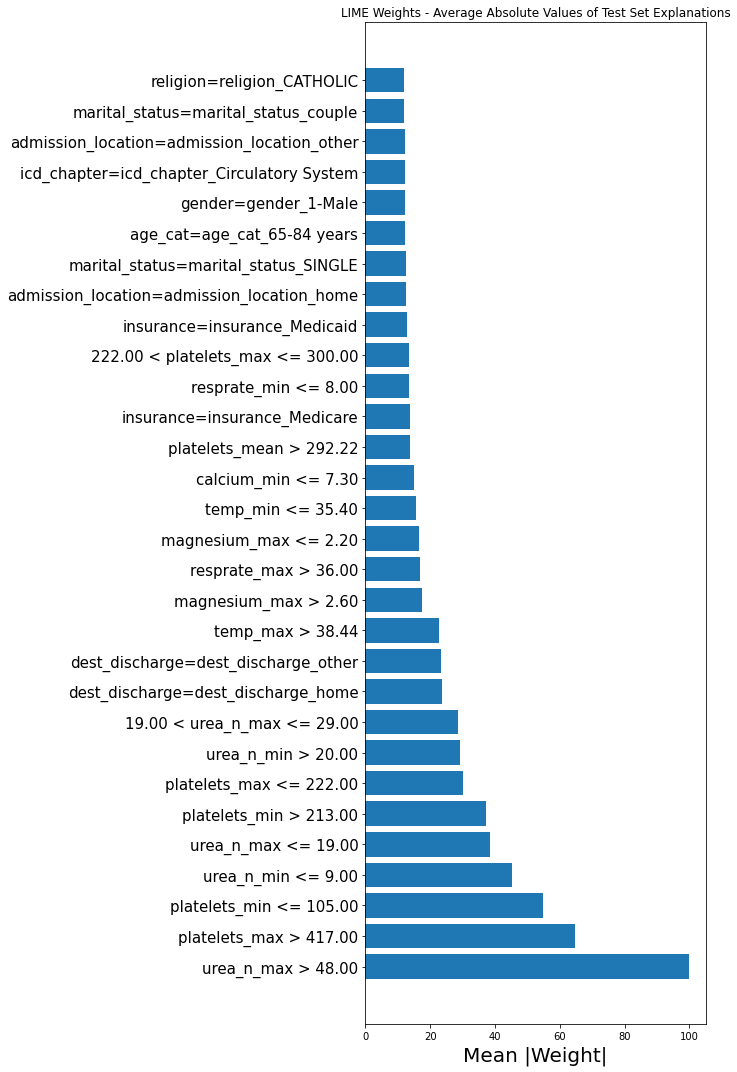

In [46]:
abs_mean_plot(weight_df, 'multimodal')

In [47]:
import re

In [48]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [49]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [50]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_clean


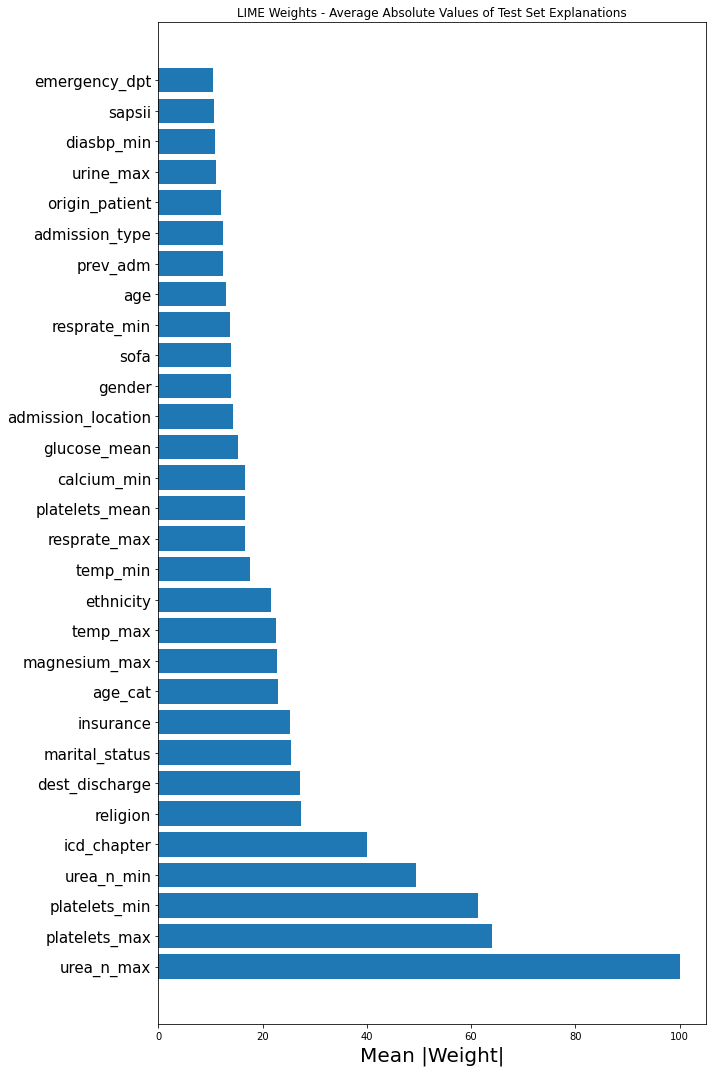

In [51]:
abs_mean_plot(count_df, 'multimodal_clean')

#### No Discretization

In [52]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [53]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [54]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


31407

In [55]:
dict_of_words = {i:0 for i in words}

In [56]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [57]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_no_discr


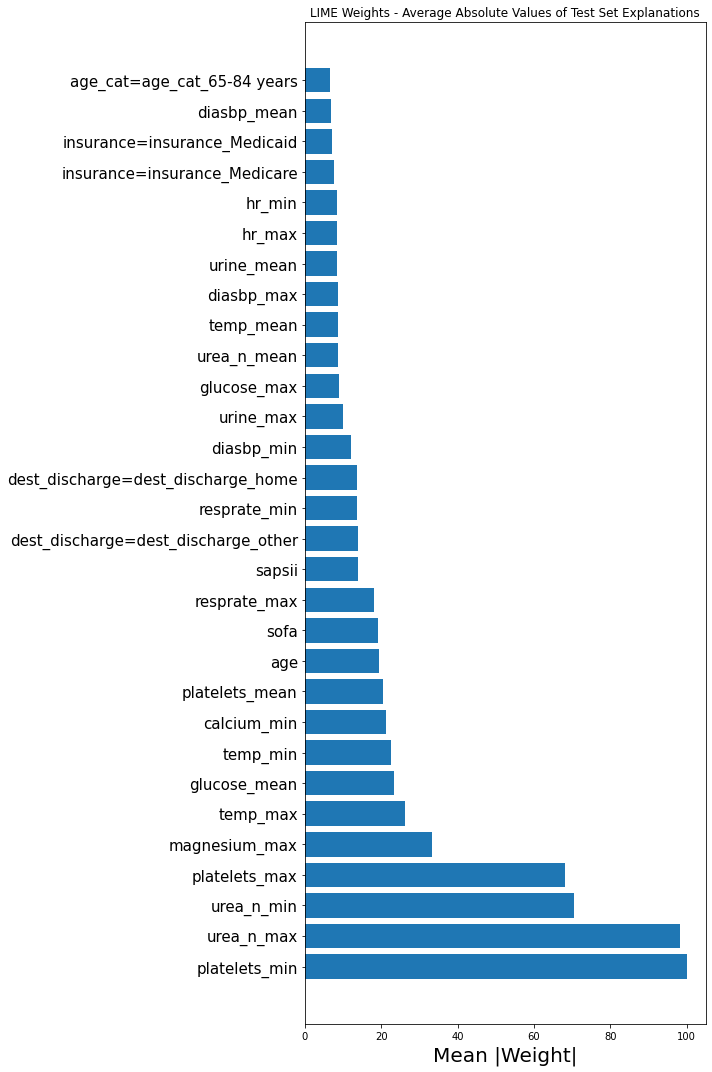

In [58]:
abs_mean_plot(weight_df, 'multimodal_no_discr')

In [59]:
import re

In [60]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [61]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [62]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_no_discr_clean


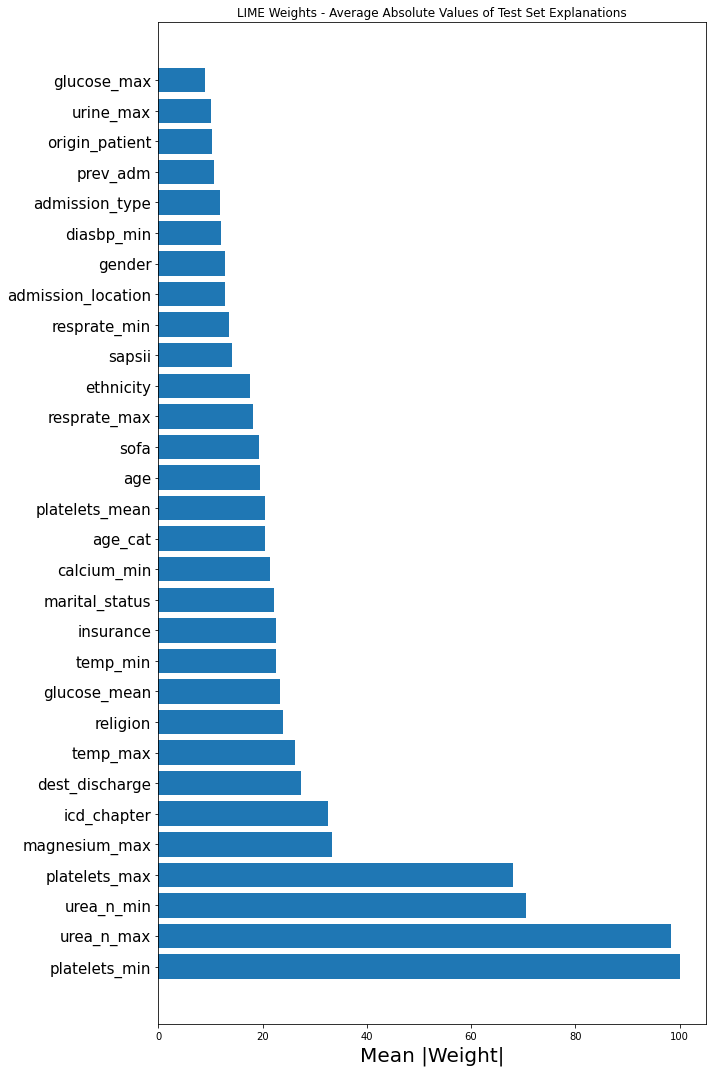

In [63]:
abs_mean_plot(count_df, 'multimodal_no_discr_clean')

#### Text Only

In [64]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [65]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [66]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

5637198


99942

In [67]:
dict_of_words = {i:0 for i in words}

In [68]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [69]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_disch_only


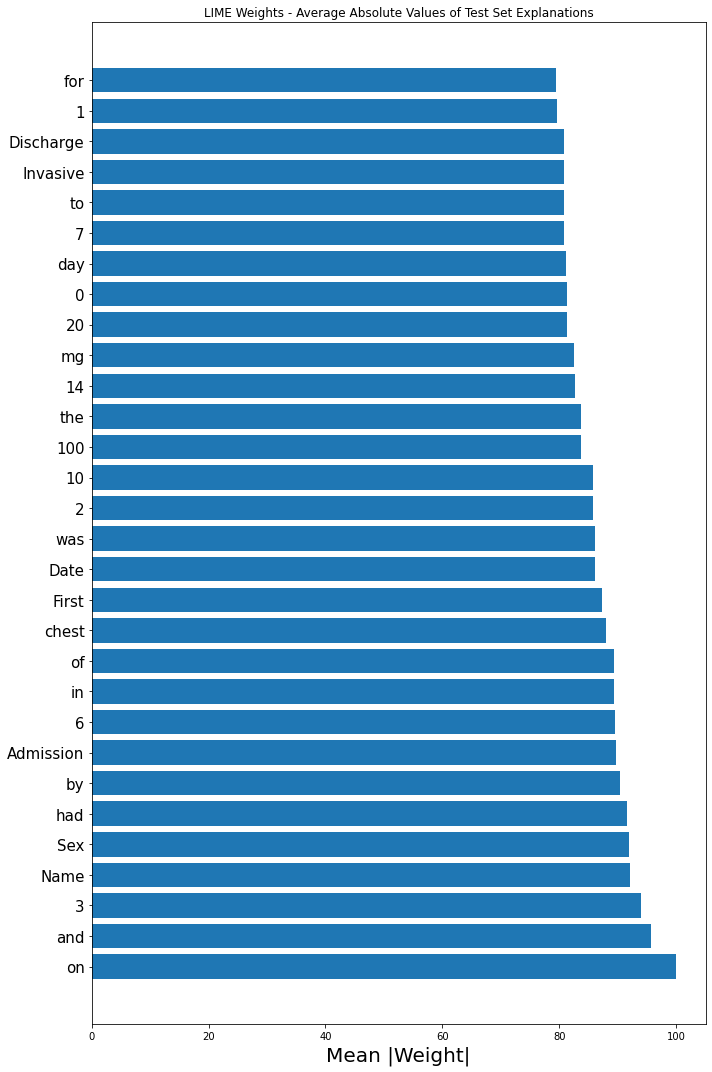

In [70]:
abs_mean_plot(weight_df, 'multimodal_disch_only')

#### Text Only No Lasso

In [71]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = False # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [72]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [73]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

775103


33739

In [74]:
dict_of_words = {i:0 for i in words}

In [ ]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [79]:
len(labels[6524])

82

In [88]:
for count, single_list in enumerate(weights):
  #print(count)
  for i, weight in enumerate(single_list):
    #print(i)
    try: dict_of_words[labels[count][i]] += abs(weight)
    except:pass

In [89]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_disch_only_no_lasso


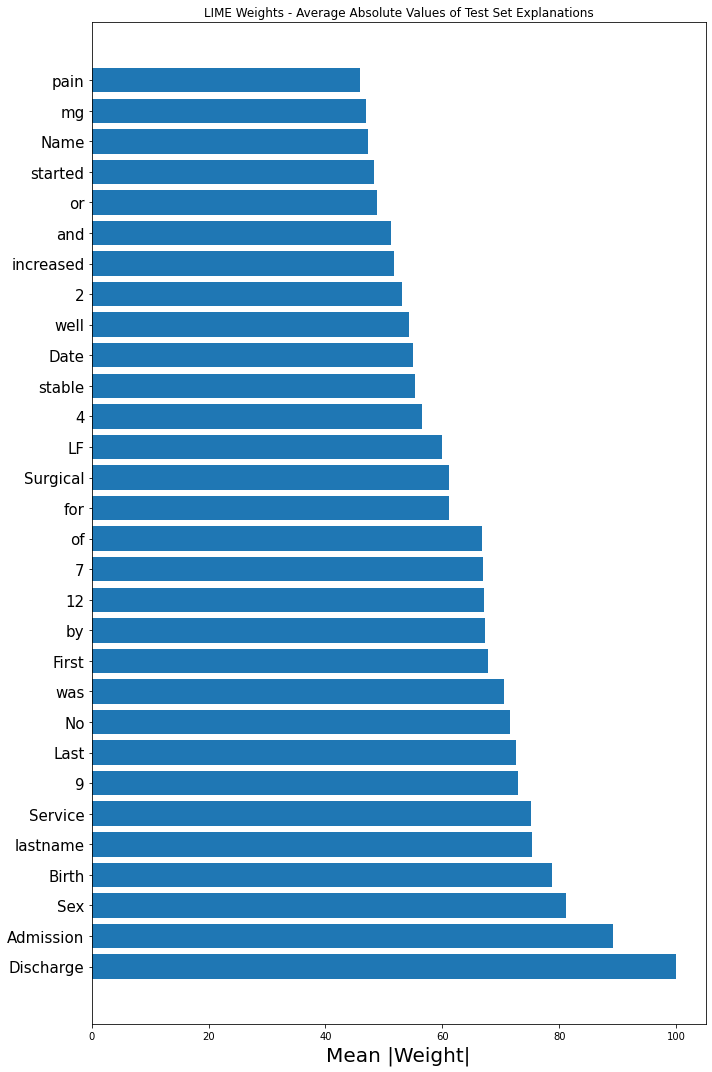

In [90]:
abs_mean_plot(weight_df, 'multimodal_disch_only_no_lasso')

### Light Preprocessing

#### LIME

In [91]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = True # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [92]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [93]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


30328

In [94]:
dict_of_words = {i:0 for i in words}

In [95]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [96]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light


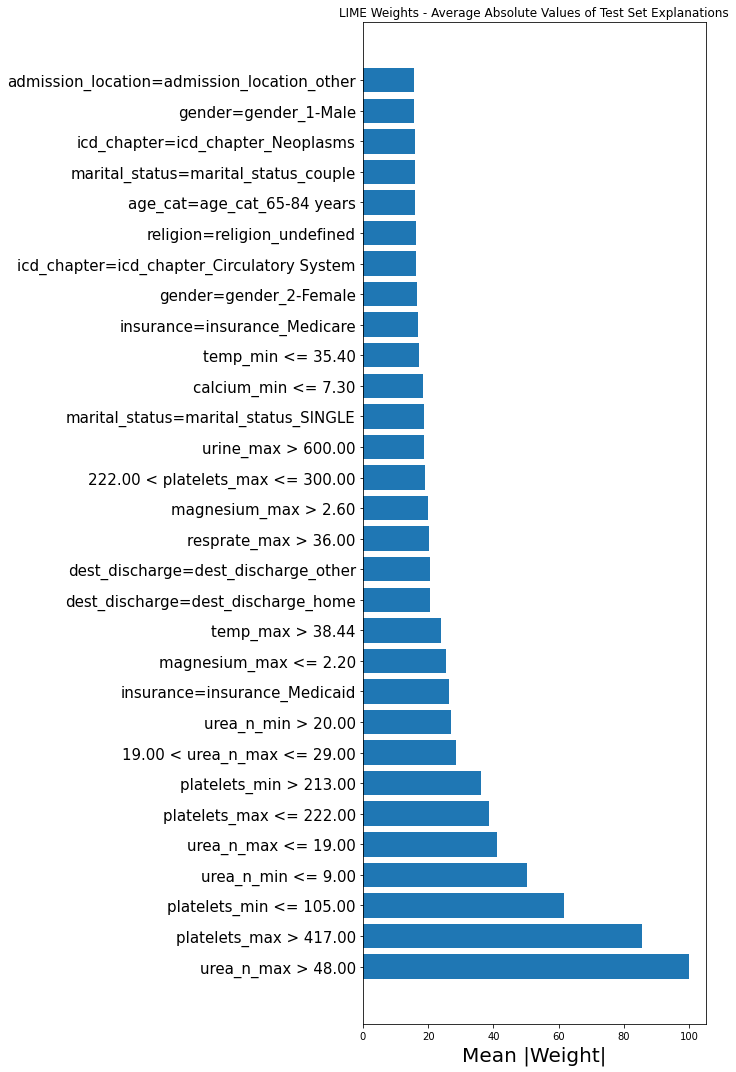

In [97]:
abs_mean_plot(weight_df, 'multimodal_light')

In [98]:
import re

In [99]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [100]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [101]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light_clean


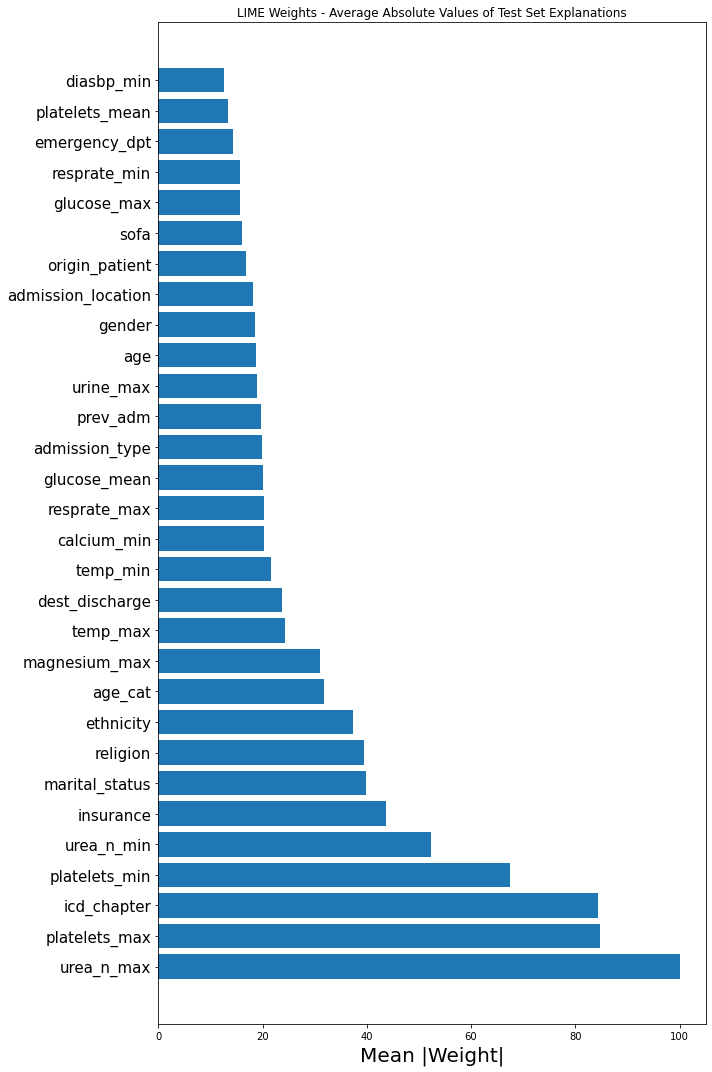

In [102]:
abs_mean_plot(count_df, 'multimodal_light_clean')

#### No Discretization

In [103]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [104]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [105]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


28266

In [106]:
dict_of_words = {i:0 for i in words}

In [107]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [108]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light_no_discr


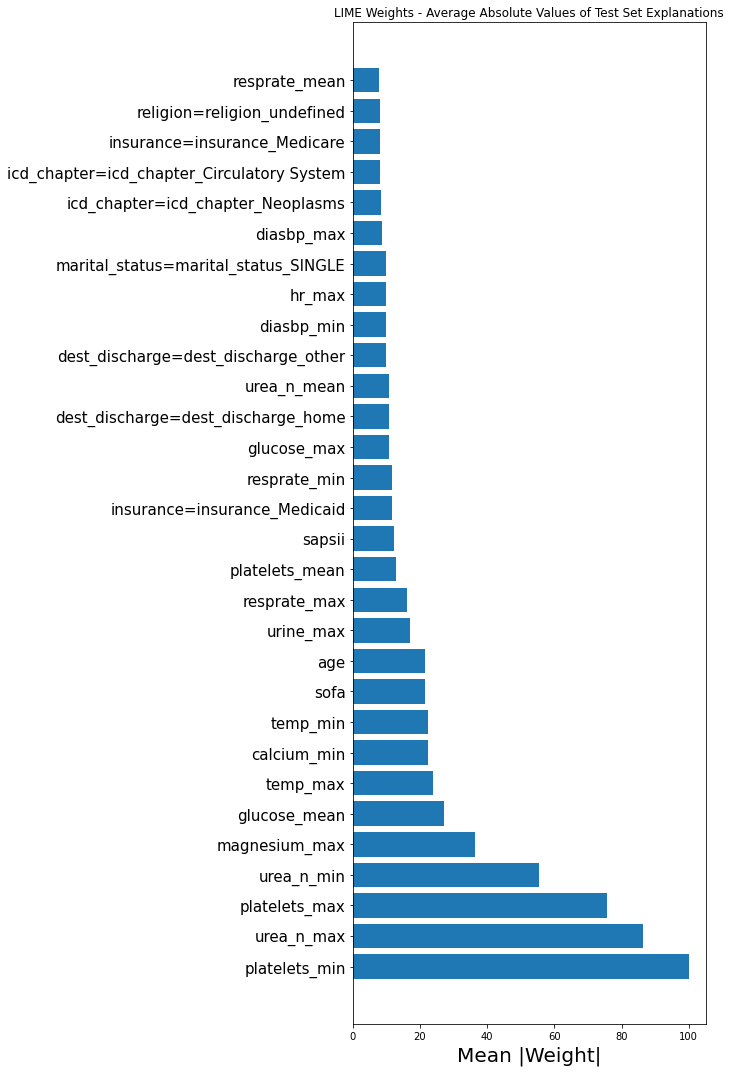

In [109]:
abs_mean_plot(weight_df, 'multimodal_light_no_discr')

In [110]:
import re

In [111]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [112]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [113]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light_no_discr_clean


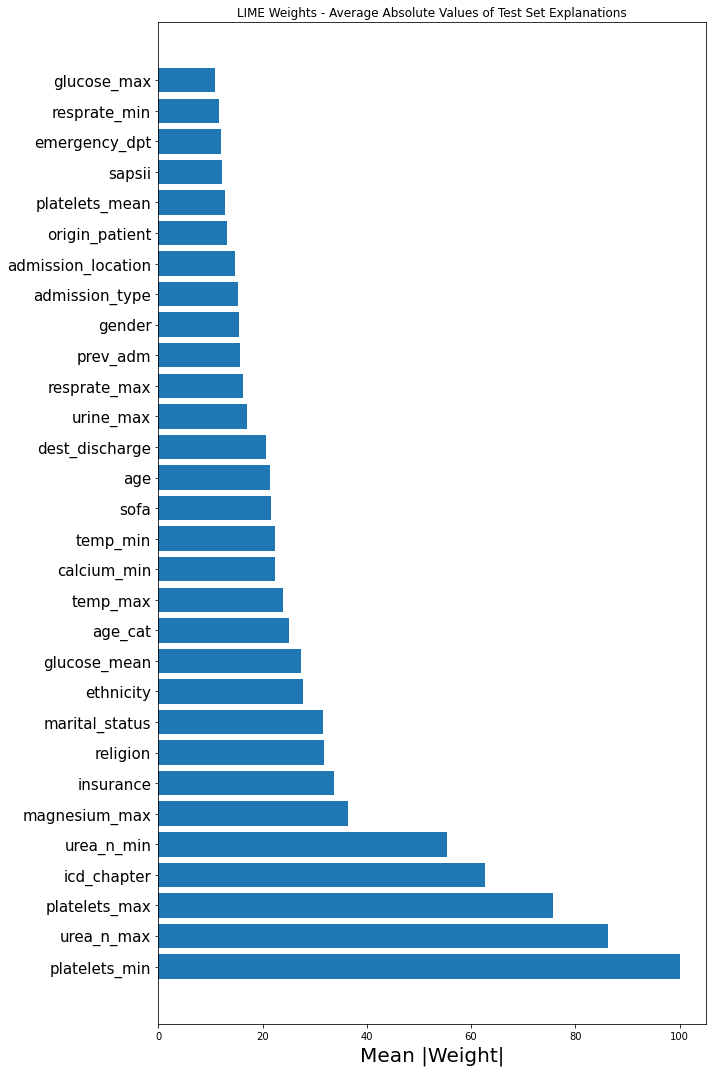

In [114]:
abs_mean_plot(count_df, 'multimodal_light_no_discr_clean')

#### Text Only

In [115]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [116]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [117]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

5365674


81699

In [118]:
dict_of_words = {i:0 for i in words}

In [119]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [120]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light_disch_only


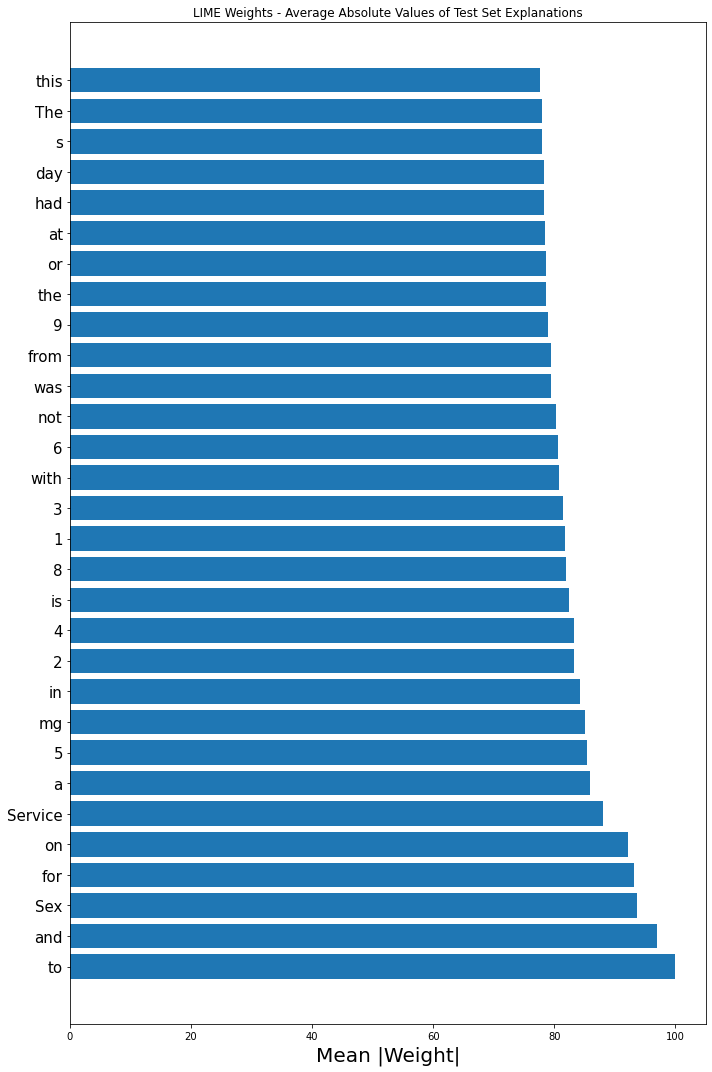

In [121]:
abs_mean_plot(weight_df, 'multimodal_light_disch_only')

#### Text Only No Lasso

In [122]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = False # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [123]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [124]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

762605


30429

In [125]:
dict_of_words = {i:0 for i in words}

In [126]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [127]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_light_disch_only_no_lasso


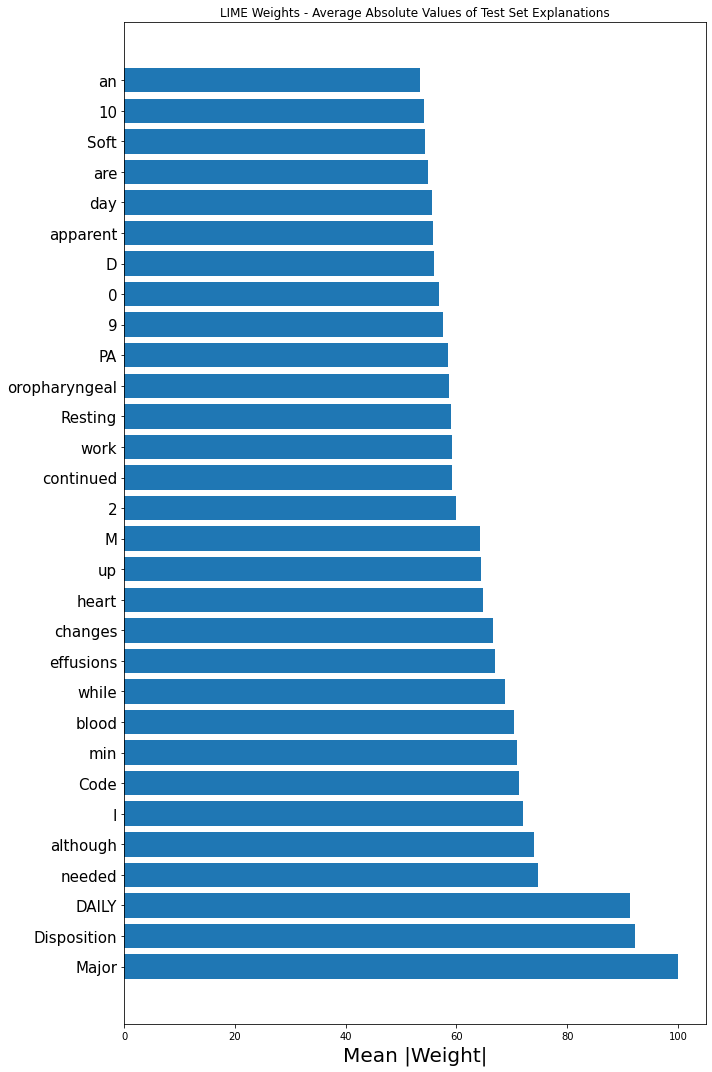

In [128]:
abs_mean_plot(weight_df, 'multimodal_light_disch_only_no_lasso')

### Heavy Preprocessing

#### LIME

In [129]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = True # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [130]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [131]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782086


36789

In [132]:
dict_of_words = {i:0 for i in words}

In [133]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [134]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy


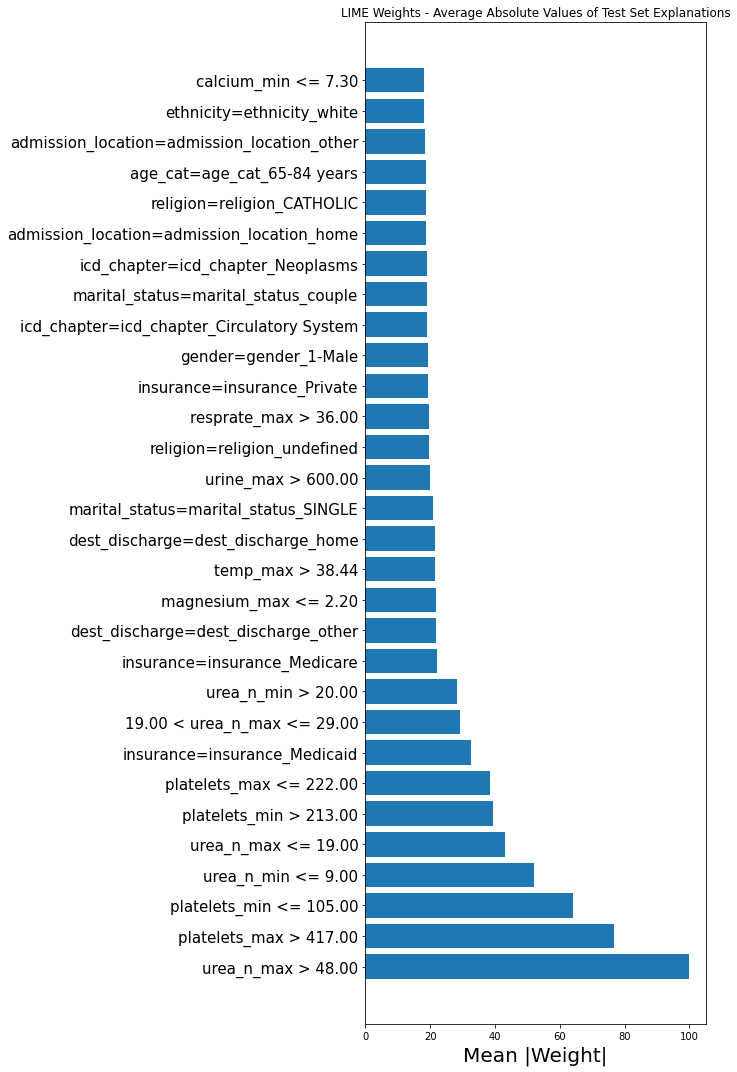

In [135]:
abs_mean_plot(weight_df, 'multimodal_heavy')

In [136]:
import re

In [137]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [138]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [139]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_clean


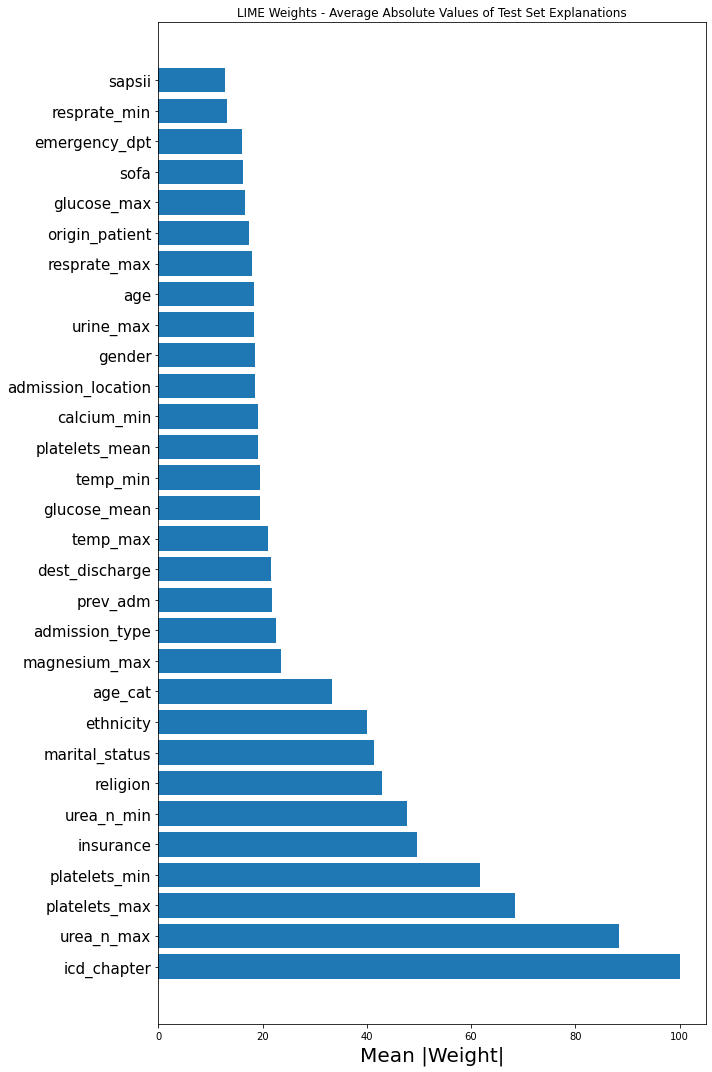

In [140]:
abs_mean_plot(count_df, 'multimodal_heavy_clean')

#### No Discretization

In [141]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [142]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [143]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782091


33583

In [144]:
dict_of_words = {i:0 for i in words}

In [145]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [146]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_no_discr


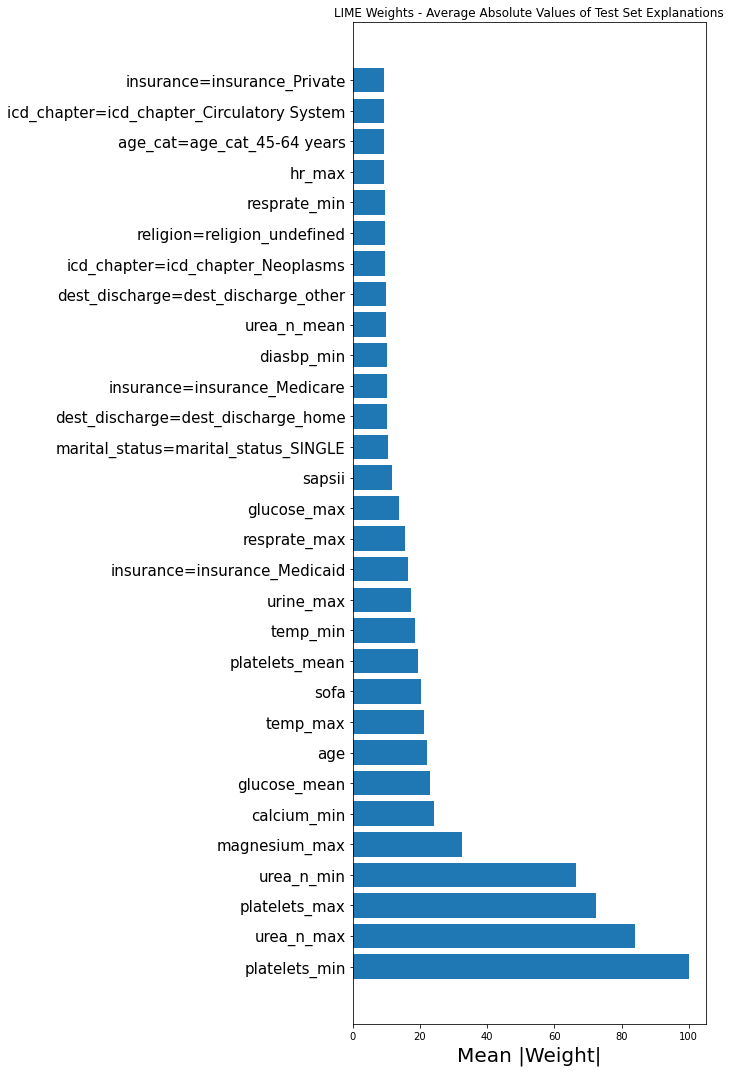

In [147]:
abs_mean_plot(weight_df, 'multimodal_heavy_no_discr')

In [148]:
import re

In [149]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [150]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [151]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_no_discr_clean


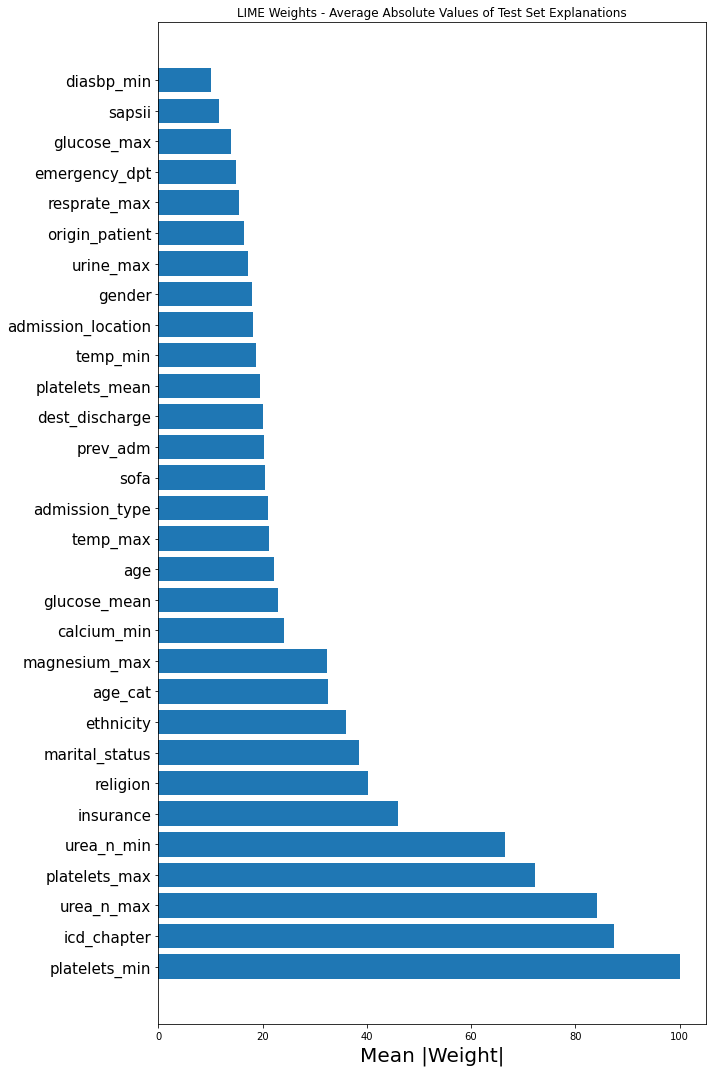

In [152]:
abs_mean_plot(count_df, 'multimodal_heavy_no_discr_clean')

#### Text Only

In [153]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [154]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [155]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

4174829


108669

In [156]:
dict_of_words = {i:0 for i in words}

In [157]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [158]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_disch_only


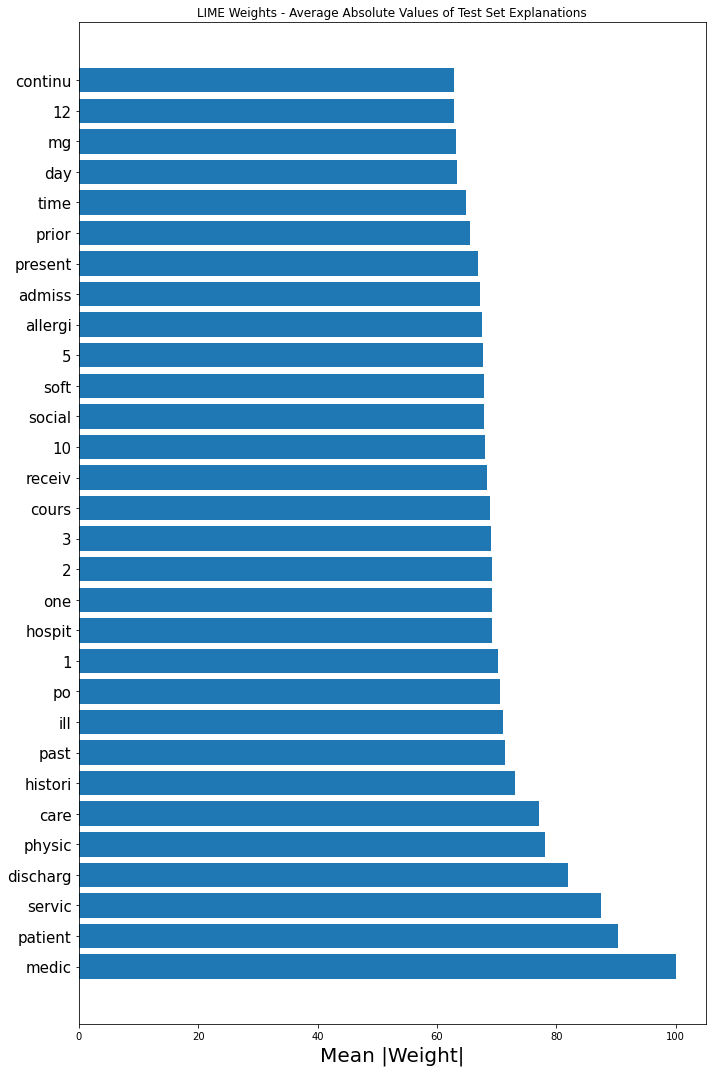

In [159]:
abs_mean_plot(weight_df, 'multimodal_heavy_disch_only')

#### Text Only No Lasso

In [160]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = False # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [161]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [162]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

753510


37361

In [163]:
dict_of_words = {i:0 for i in words}

In [164]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [165]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_disch_only_no_lasso


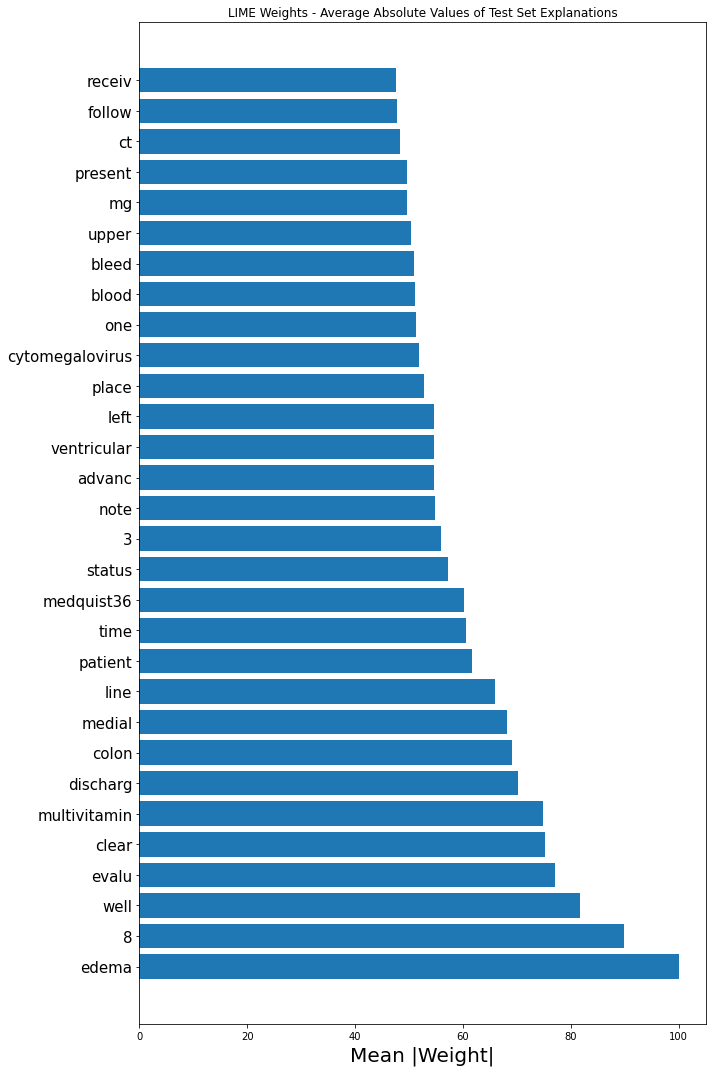

In [166]:
abs_mean_plot(weight_df, 'multimodal_heavy_disch_only_no_lasso')

### Heavy Preprocessing Lemma

#### LIME

In [167]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = True # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [168]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [169]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782093


38818

In [170]:
dict_of_words = {i:0 for i in words}

In [171]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [172]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemma


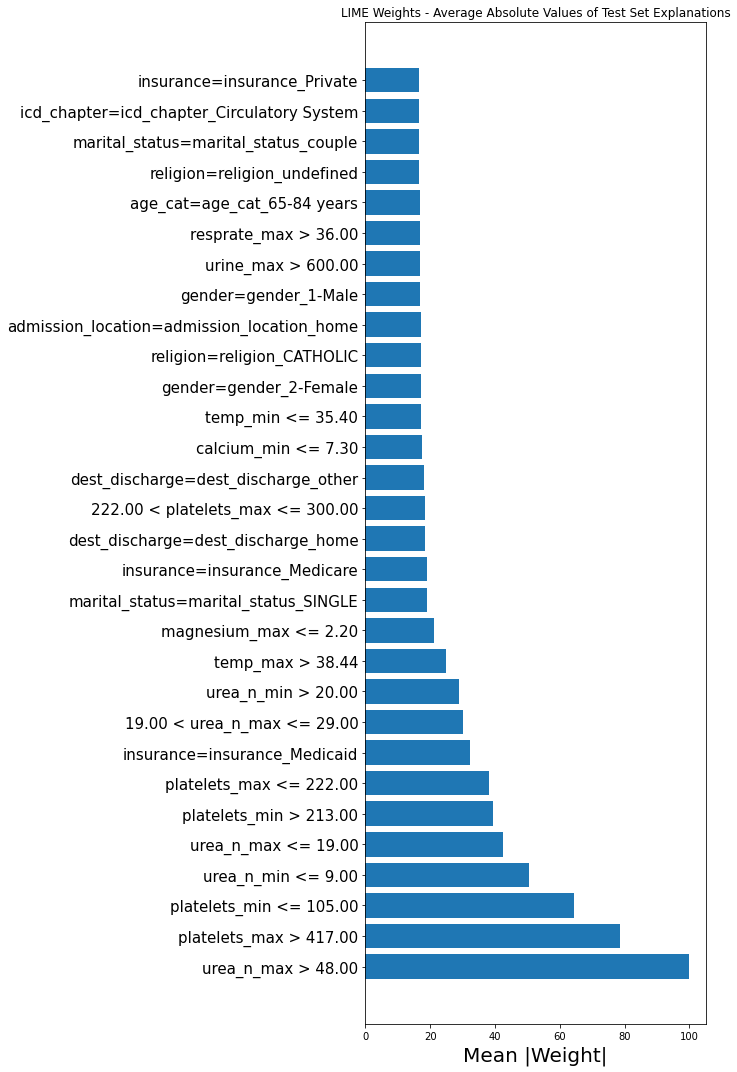

In [173]:
abs_mean_plot(weight_df, 'multimodal_heavy_lemma')

In [174]:
import re

In [175]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [176]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [177]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemmma_clean


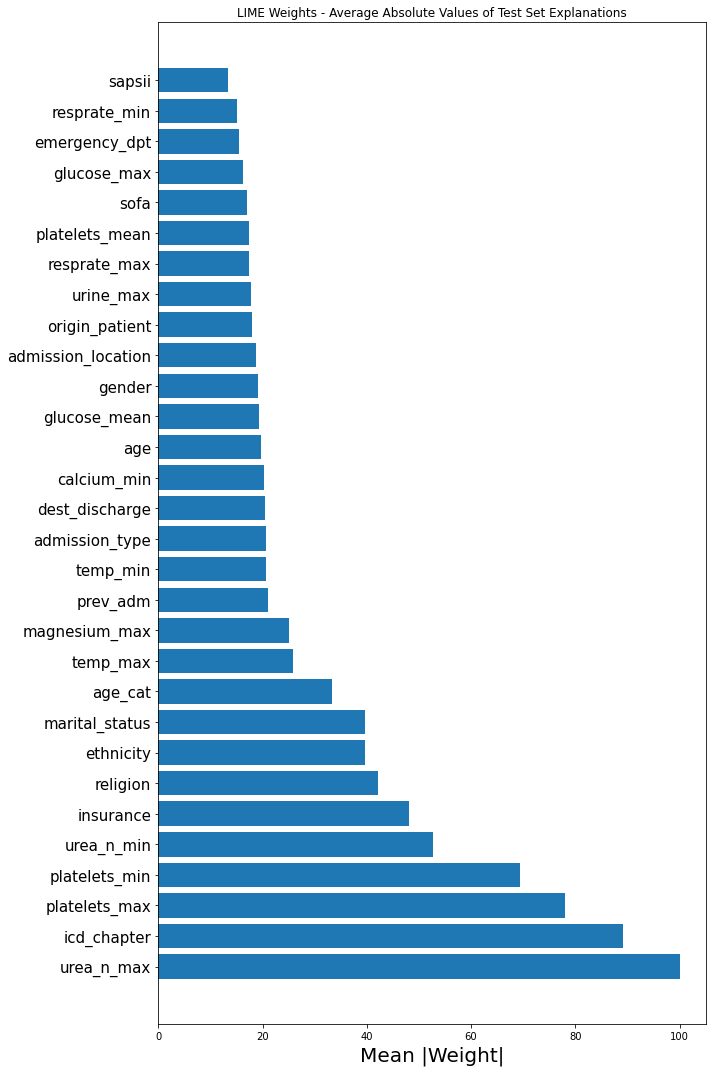

In [178]:
abs_mean_plot(count_df, 'multimodal_heavy_lemmma_clean')

#### No Discretization

In [179]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [180]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [181]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782098


35450

In [182]:
dict_of_words = {i:0 for i in words}

In [183]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [184]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemmma_no_discr


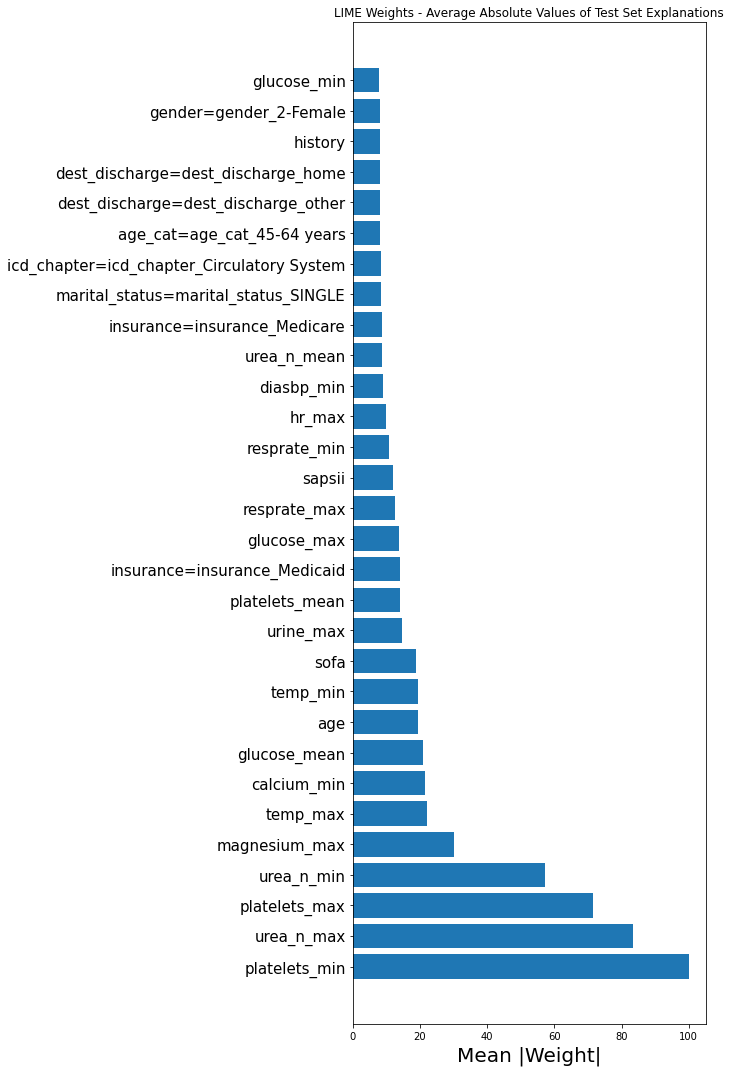

In [185]:
abs_mean_plot(weight_df, 'multimodal_heavy_lemmma_no_discr')

In [186]:
import re

In [187]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [188]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [189]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemmma_no_discr_clean


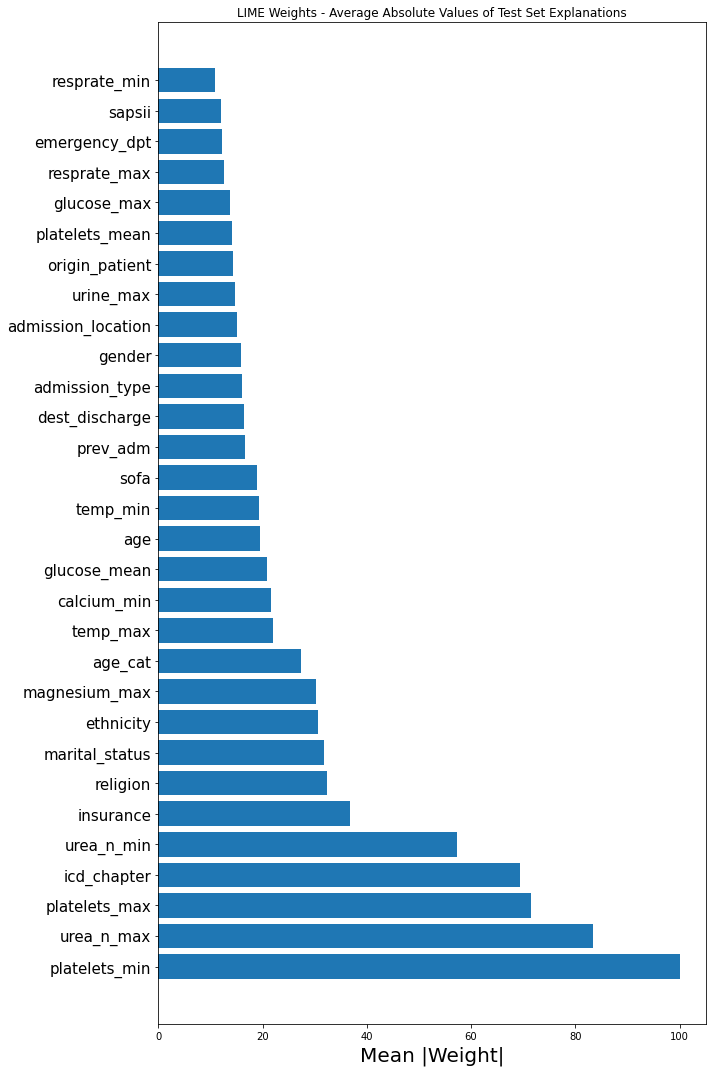

In [190]:
abs_mean_plot(count_df, 'multimodal_heavy_lemmma_no_discr_clean')

#### Text Only

In [191]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [192]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [193]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

4260972


115534

In [194]:
dict_of_words = {i:0 for i in words}

In [195]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [196]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemmma_disch_only


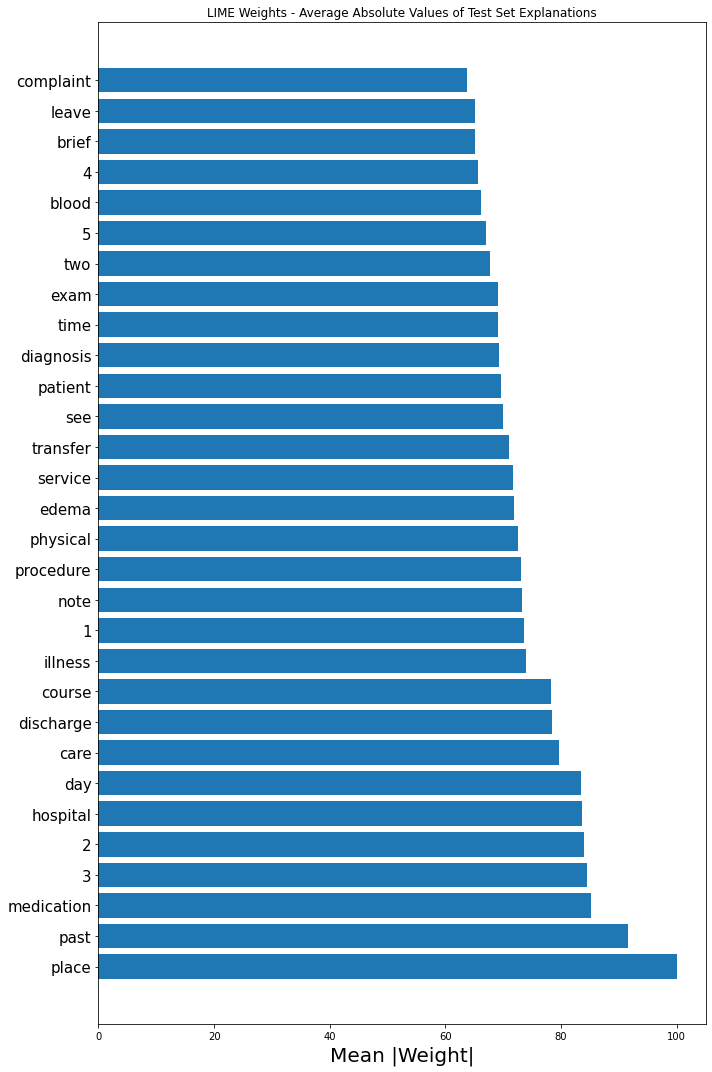

In [197]:
abs_mean_plot(weight_df, 'multimodal_heavy_lemmma_disch_only')

#### Text Only No Lasso

In [198]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'multimodal' # either "multimodal" or "text_mixed"
lime_discharge_only = True # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = False # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [199]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [200]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

753806


39275

In [201]:
dict_of_words = {i:0 for i in words}

In [202]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [203]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/multimodal_heavy_lemmma_disch_only_no_lasso


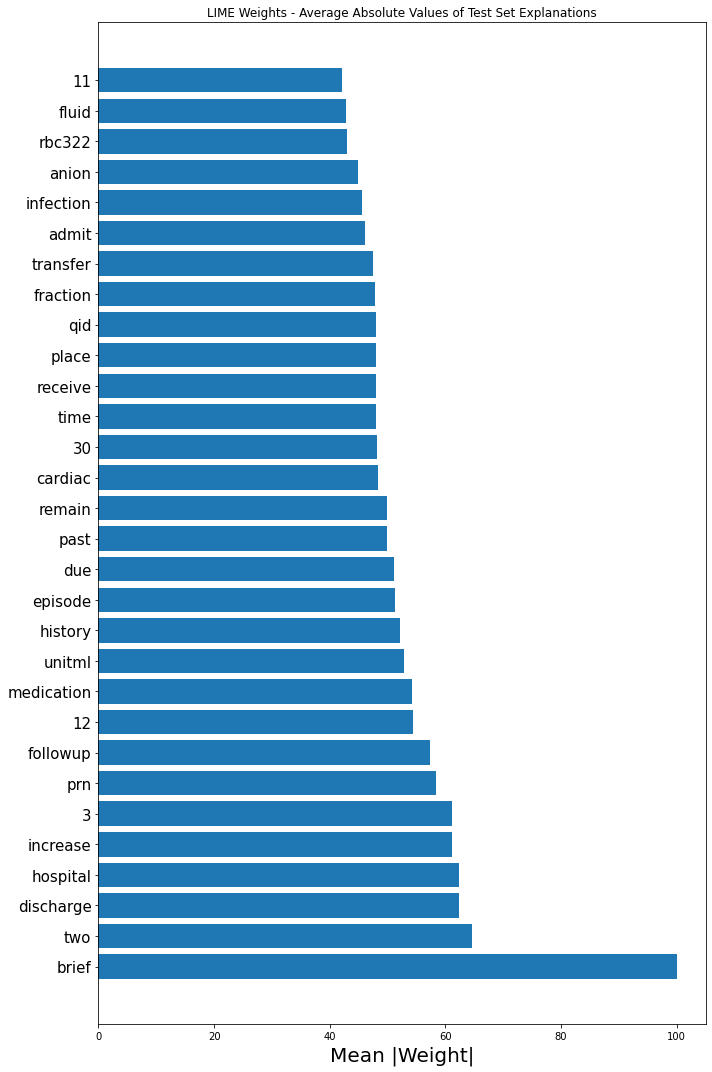

In [204]:
abs_mean_plot(weight_df, 'multimodal_heavy_lemmma_disch_only_no_lasso')

## Text Mixed

### No Preprocessing

#### LIME

In [205]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'text_mixed' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [206]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [207]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


32353

In [208]:
dict_of_words = {i:0 for i in words}

In [209]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [210]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed


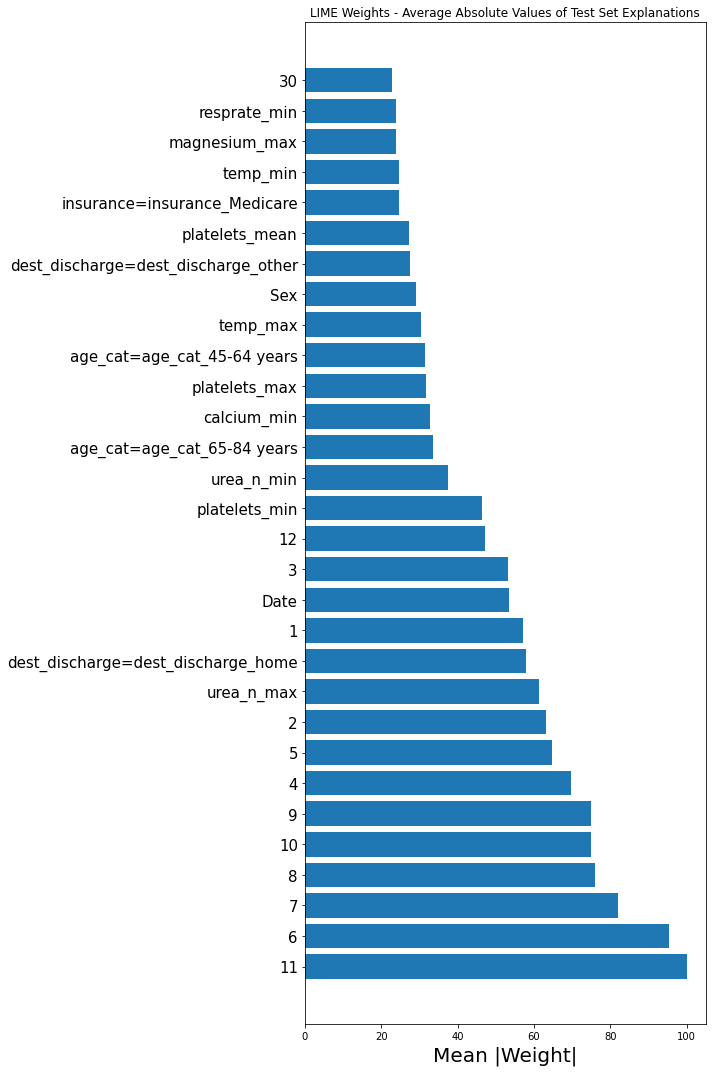

In [211]:
abs_mean_plot(weight_df, 'text_mixed')

In [212]:
import re

In [213]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [214]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [215]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_clean


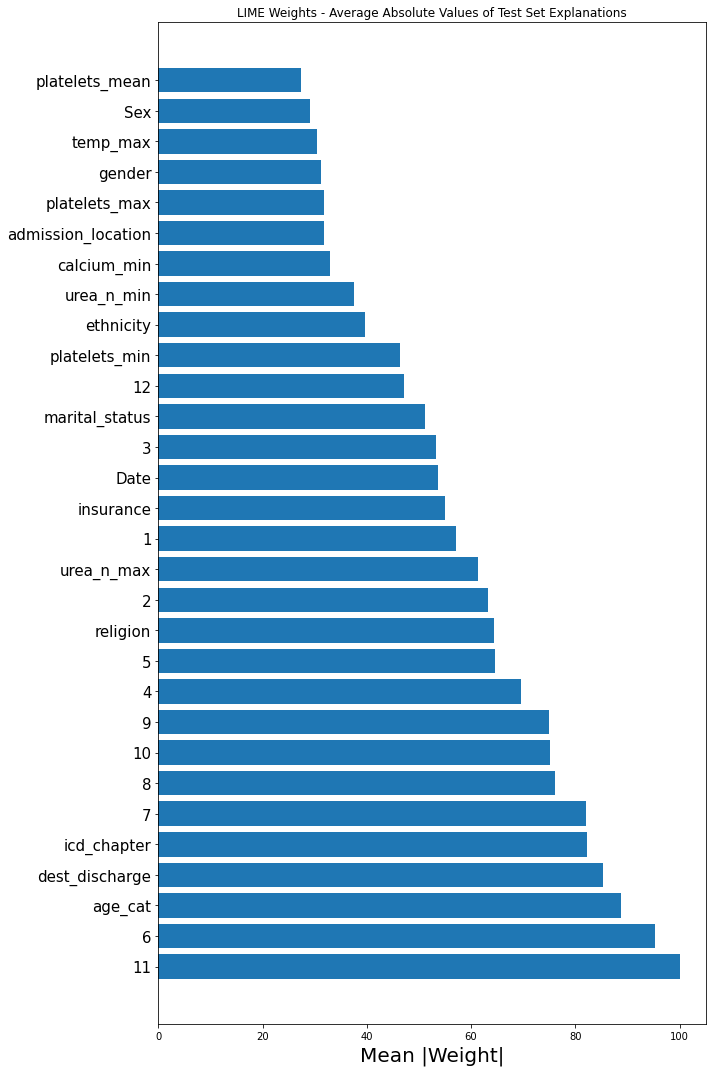

In [216]:
abs_mean_plot(count_df, 'text_mixed_clean')

#### LIME - Condense Dates

In [217]:
# import dataset
file = '/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_mixed_discharge.csv'
raw_df = pd.read_csv(file, low_memory=False)

In [218]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['Unnamed: 0', 'HADM_ID', 'subject_id','icu_los'])

In [219]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(39841, 39105)

In [220]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])

In [221]:
# drop variables having more than 20 % missing values
df = df.drop(columns=['albumin_min','patientweight','type_stay'])

In [222]:
# save df
df_copy = df.copy()

In [223]:
# impute missing values
df = df_copy.interpolate()

In [224]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.142, Third Quartile = 14.506, Interquartile Interval = 9.365
Lower Fence = -8.905, Upper Fence = 28.553


In [225]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF

In [226]:
# restrict to just discharge notes
df = df[['los_cat', 'discharge']]

In [227]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

In [228]:
df_test['weights'] = weights
df_test['labels'] = labels

In [229]:
import re

In [230]:
def extract_adm(text):
  date = re.search(r'Admission Date:\s+\[\*\*(.+?)\*\*\]', text, flags = re.IGNORECASE)
  try:
    date = date.group(0)
  except:
    date = 'Missing'
  return date

def extract_disch(text):
  date = re.search(r'Discharge Date:\s+\[\*\*(.+?)\*\*\]', text, flags = re.IGNORECASE)
  try:
    date = date.group(0)
  except:
    date = 'Missing'
  return date

In [231]:
df_test['admission_date'] = df_test.discharge.apply(lambda x: extract_adm(x))
df_test['discharge_date'] = df_test.discharge.apply(lambda x: extract_disch(x))

In [232]:
df_test.shape

(7821, 6)

In [233]:
df_test_clean = df_test.loc[df_test.admission_date != 'Missing']

In [234]:
df_test_clean.shape

(7804, 6)

In [235]:
df_test_clean = df_test_clean.loc[df_test_clean.discharge_date != 'Missing']
df_test_clean.shape

(7727, 6)

In [236]:
def clean_date(text):
  text = re.sub(r'(Admission|Discharge) Date:\s+\[\*\*', "", text)
  text = re.sub(r'\*\*\]', '', text)
  return text

In [237]:
df_test_clean['admission_date'] = df_test_clean.admission_date.apply(lambda x: clean_date(x))
df_test_clean['discharge_date'] = df_test_clean.discharge_date.apply(lambda x: clean_date(x))

In [238]:
def check_if_dates(x):
  label_clean = []
  for i in x['labels']:
    if bool(re.search(i, x["admission_date"])) or bool(re.search(i, x["admission_date"])):
      label_clean.append('date_placeholder')
    else:
      label_clean.append(i)
  return label_clean

In [239]:
df_test_clean['label_clean'] = df_test_clean.apply(lambda x: check_if_dates(x), axis = 1)

In [240]:
df_test_clean.reset_index(inplace = True, drop = True)

In [241]:
labels_clean = df_test_clean.label_clean.tolist()
weights_clean = df_test_clean.weights.tolist()

In [242]:
words = [word for single_list in labels_clean for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

772700


32192

In [243]:
dict_of_words = {i:0 for i in words}

In [244]:
for count, single_list in enumerate(weights_clean):
  for i, weight in enumerate(single_list):
    dict_of_words[labels_clean[count][i]] += abs(weight)

In [245]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_dates


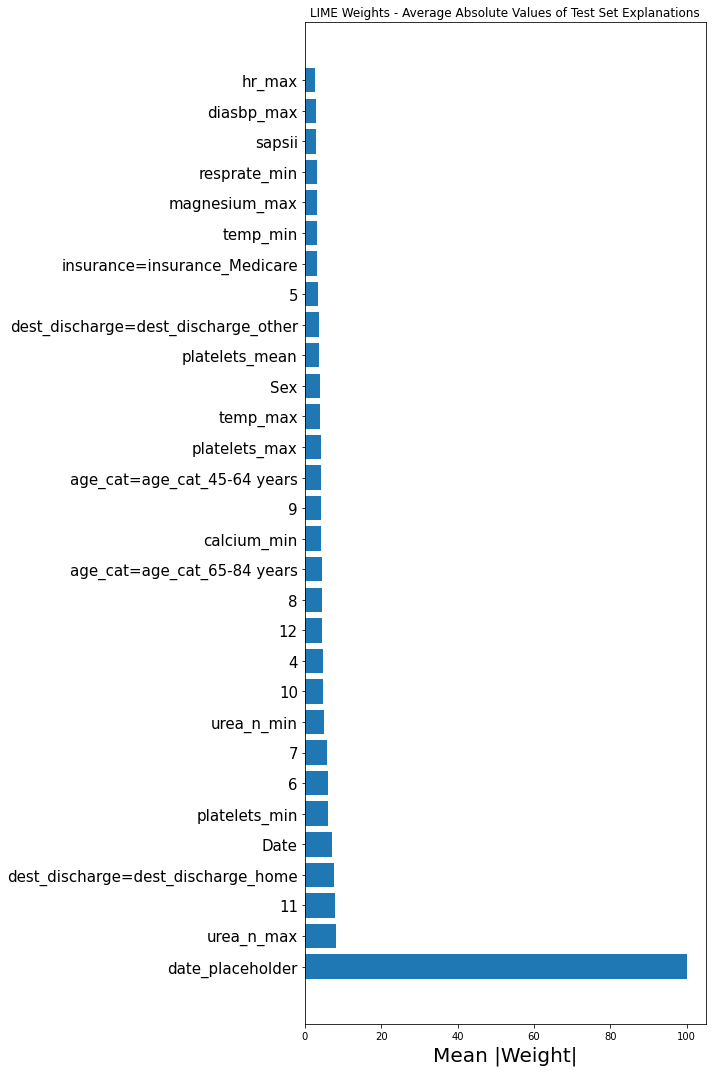

In [246]:
abs_mean_plot(weight_df, 'text_mixed_dates')

### Light Preprocessing

#### LIME

In [247]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'text_mixed' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [248]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [249]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782100


28019

In [250]:
dict_of_words = {i:0 for i in words}

In [251]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [252]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_light


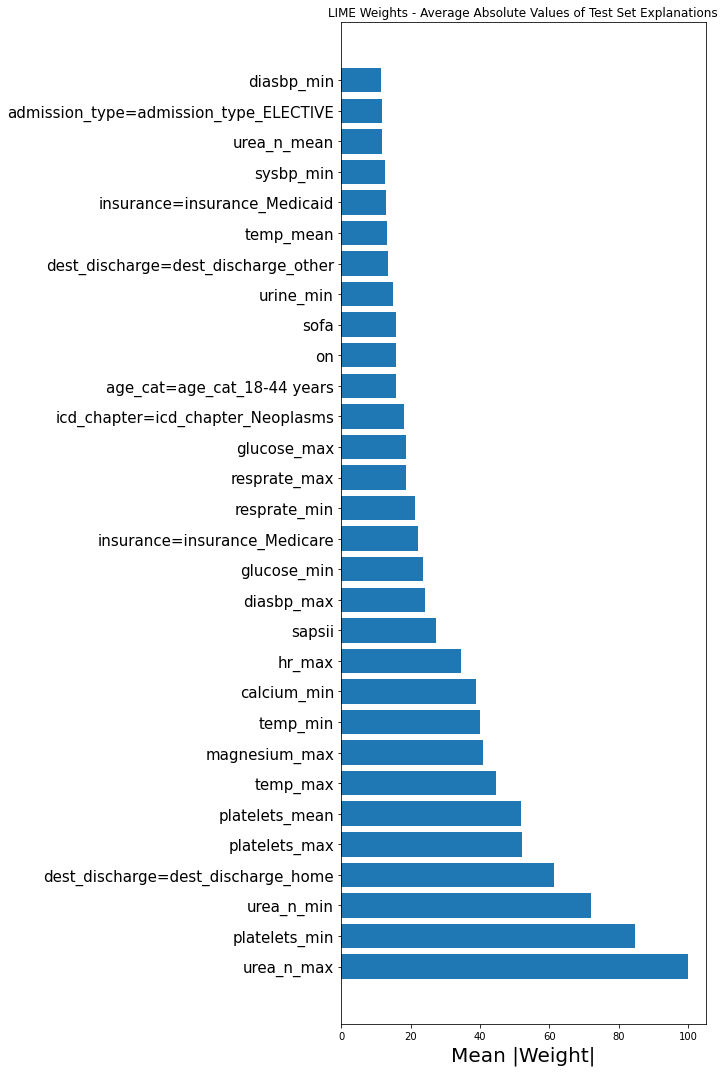

In [253]:
abs_mean_plot(weight_df, 'text_mixed_light')

In [254]:
import re

In [255]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [256]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [257]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_light_clean


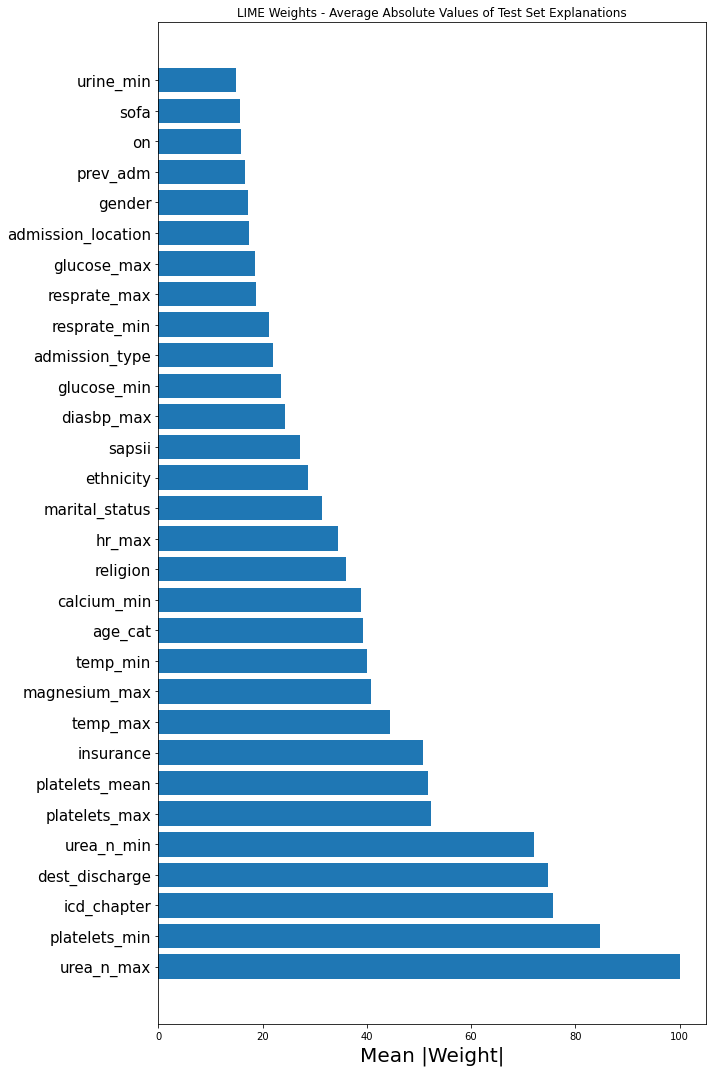

In [258]:
abs_mean_plot(count_df, 'text_mixed_light_clean')

### Heavy Preprocessing

#### LIME

In [259]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'text_mixed' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = False # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [260]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [261]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782094


32592

In [262]:
dict_of_words = {i:0 for i in words}

In [263]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [264]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy


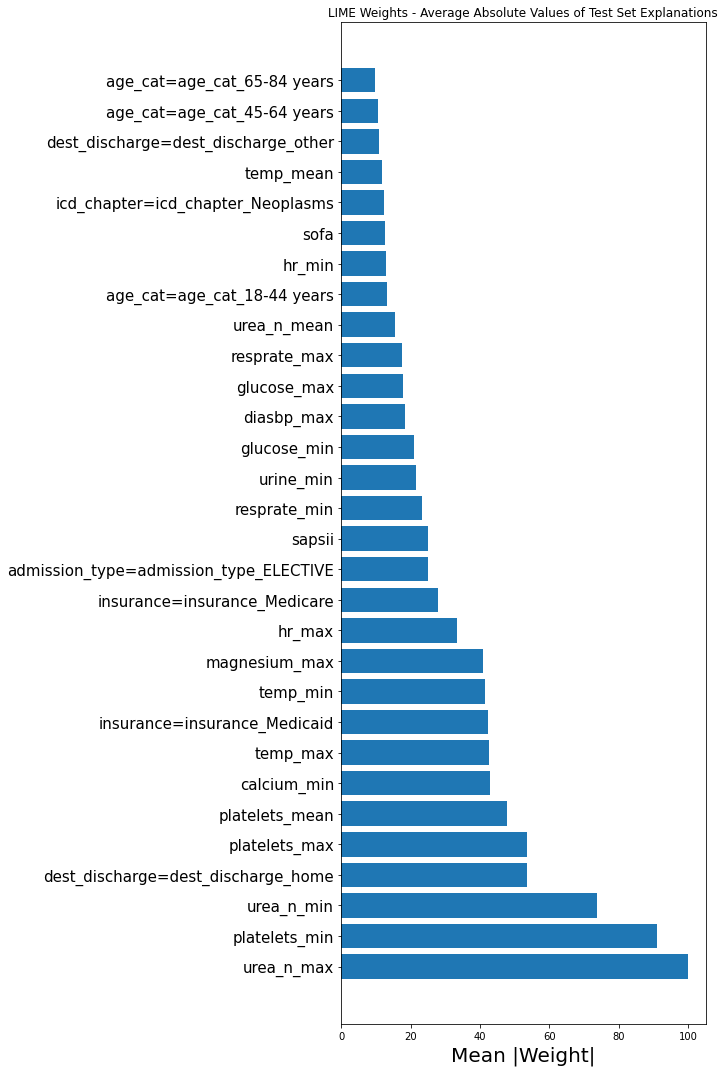

In [265]:
abs_mean_plot(weight_df, 'text_mixed_heavy')

In [266]:
import re

In [267]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [268]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [269]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy_cleaned


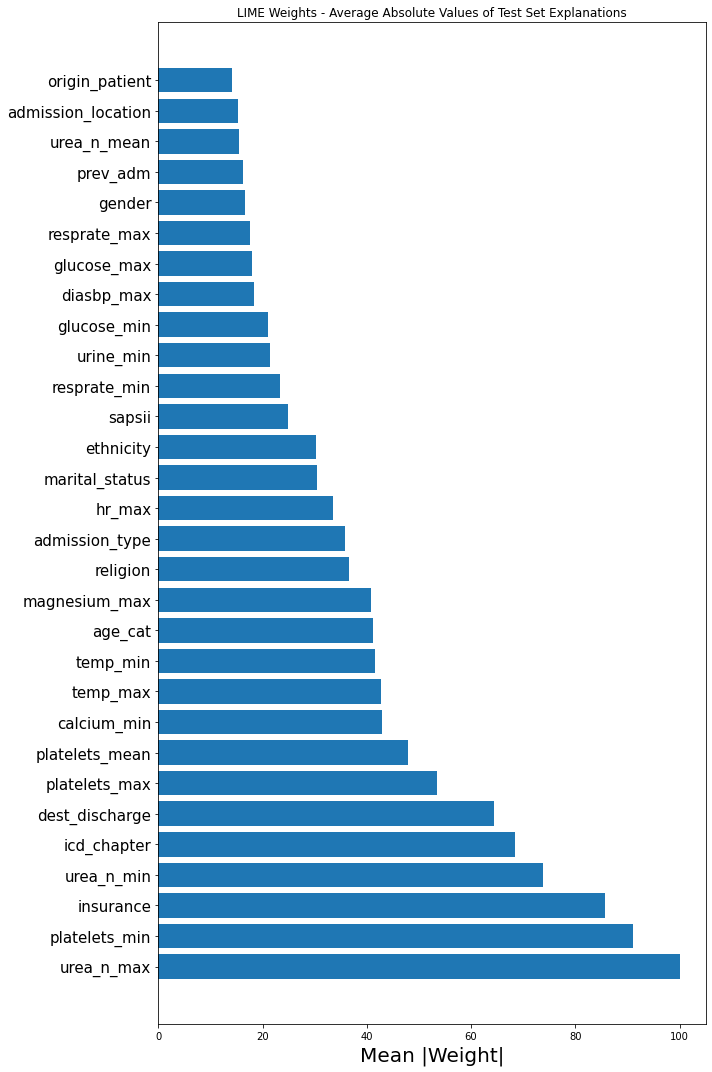

In [270]:
abs_mean_plot(count_df, 'text_mixed_heavy_cleaned')

### Heavy Preprocessing Lemma

#### LIME

In [271]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = False # set to True if we want to discretize numerical features
model_explained = 'text_mixed' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [272]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [273]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782099


34558

In [274]:
dict_of_words = {i:0 for i in words}

In [275]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [276]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy_lemma


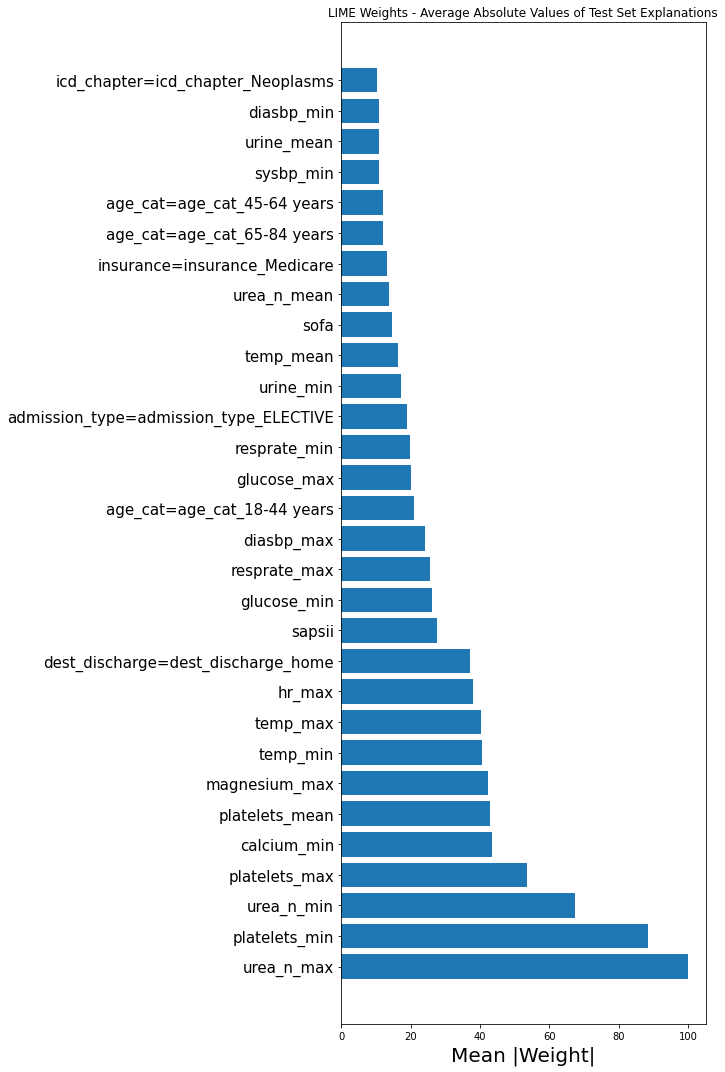

In [277]:
abs_mean_plot(weight_df, 'text_mixed_heavy_lemma')

In [278]:
import re

In [279]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [280]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [281]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy_lemma_clean


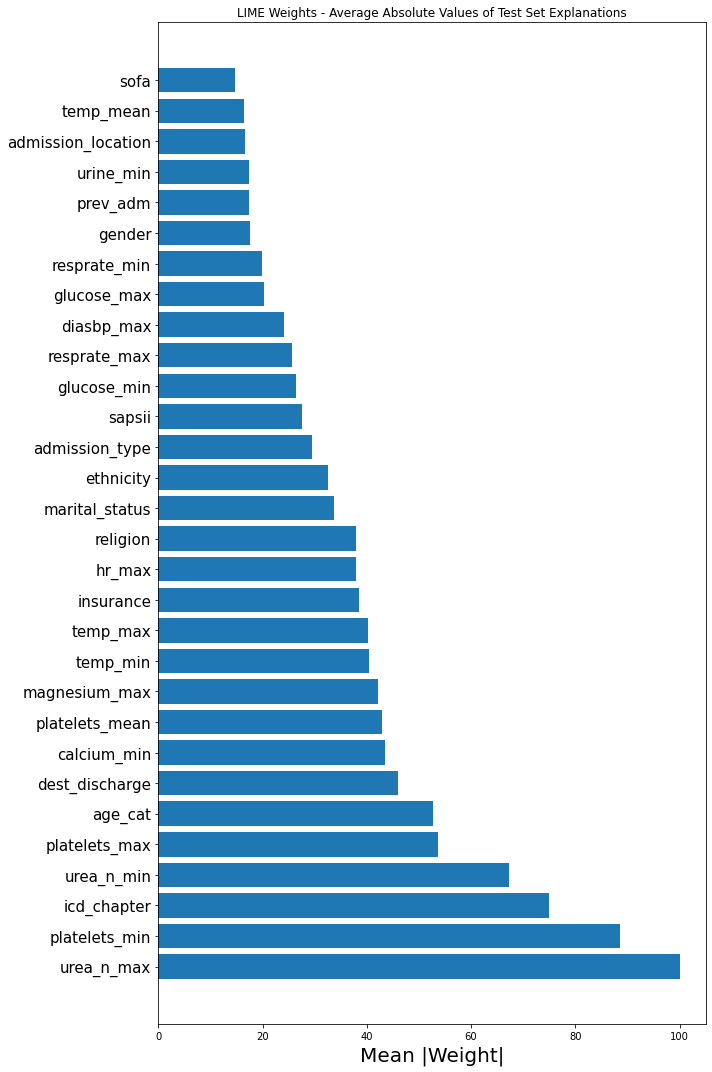

In [282]:
abs_mean_plot(count_df, 'text_mixed_heavy_lemma_clean')

#### With Discretization

In [283]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
do_discretization = True # set to True if we want to discretize numerical features
model_explained = 'text_mixed' # either "multimodal" or "text_mixed"
lime_discharge_only = False # set to True if we want to explain only discharge note features
lemmatization = True # set to True if we want to lemmatize
lasso_selection = True # set to True if we want lasso selection


preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
preproc_tag = np.where(lemmatization, f'{preproc_tag}_lemmatization' , preproc_tag)
discretization_tag = np.where(do_discretization, '', '_no_discr')
discretization_tag = np.where(lime_discharge_only, '_disch_only', discretization_tag) # if we explain discharge only, we override discretization/not use it
discretization_tag = np.where(lasso_selection, discretization_tag, f'{discretization_tag}_no_lasso')

In [284]:
# load weights
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_weights{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        weights = pickle.load(handle)
        print('Weights loaded')
        print(len(weights))
except :
    weights = [] # initialize an empty dictionary if no existing file is present
    print('New Weight List')
# load labels
try :
    with open(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/feature_importance/{model_explained}_labels{preproc_tag}{discretization_tag}.pkl', 'rb') as handle:
        labels = pickle.load(handle)
        print('Label Loaded')
        print(len(labels))
except :
    labels = [] # initialize an empty dictionary if no existing file is present
    print('New Label List')

Weights loaded
7821
Label Loaded
7821


In [285]:
words = [word for single_list in labels for word in single_list]
print(len(words))
words = list(set(words)) # get unique values
len(words)

782091


38389

In [286]:
dict_of_words = {i:0 for i in words}

In [287]:
for count, single_list in enumerate(weights):
  for i, weight in enumerate(single_list):
    dict_of_words[labels[count][i]] += abs(weight)

In [288]:
weight_df = pd.DataFrame([dict_of_words.keys(), dict_of_words.values()]).T
weight_df.columns = ['word', 'weight']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy_lemma


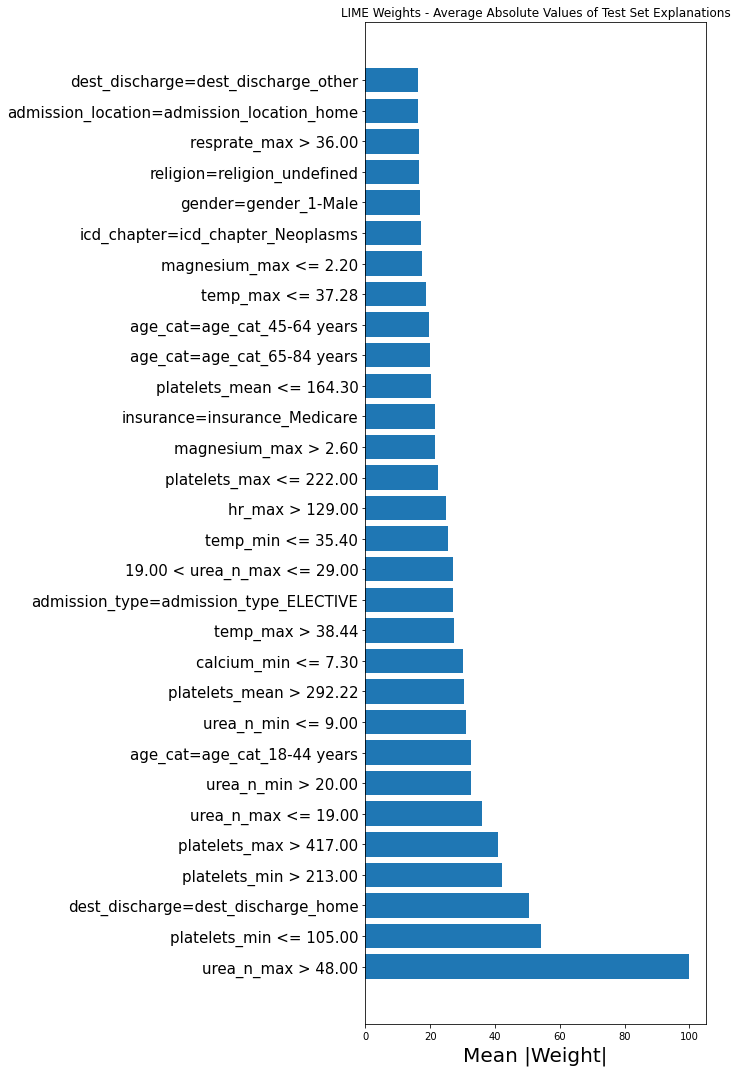

In [289]:
abs_mean_plot(weight_df, 'text_mixed_heavy_lemma')

In [290]:
import re

In [291]:
def find_lower(text):
  try:
    text = re.findall(r'(?<=<|>).*$', text)[0]
    return text
  except:
    return text

In [292]:
weight_df['word_clean'] = weight_df.word.apply(lambda x: re.sub(r'((<|>|)=|(<|>) [0-9]+).*',"", x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: find_lower(x))
weight_df['word_clean'] = weight_df.word_clean.apply(lambda x: x.strip())

In [293]:
count_df = weight_df.groupby('word_clean').sum()
count_df.reset_index(inplace = True, drop = False)
count_df['word'] = count_df['word_clean']

Saving figure /content/drive/MyDrive/MIMIC-III Text Mining/LOS/figures/text_mixed_heavy_lemma_clean


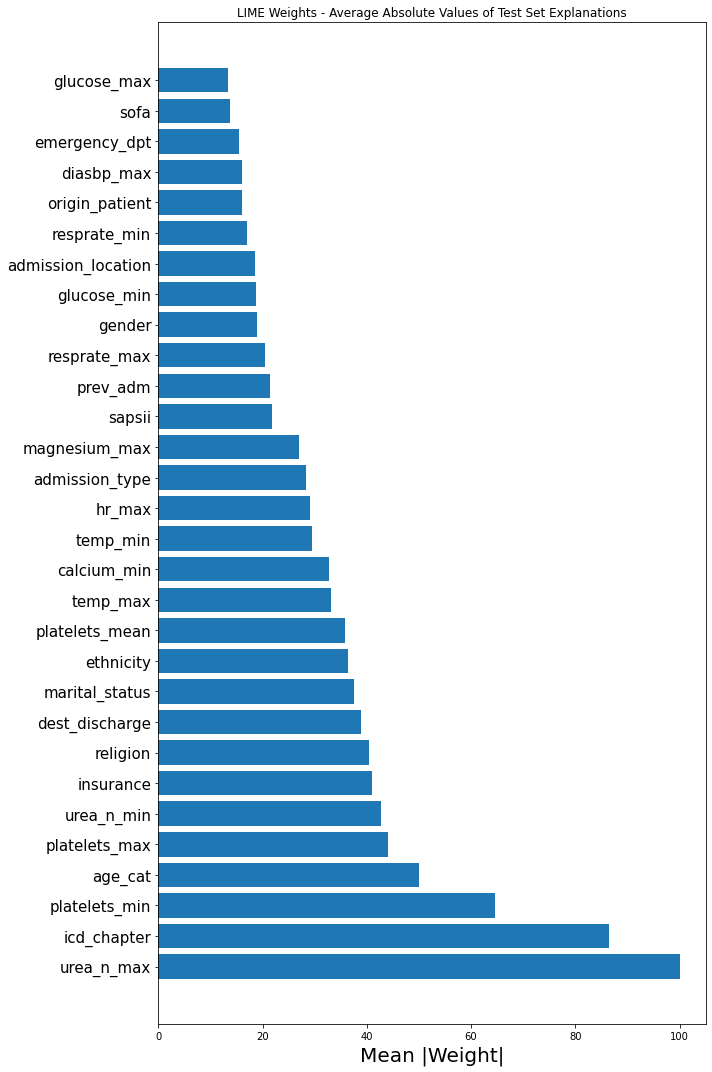

In [294]:
abs_mean_plot(count_df, 'text_mixed_heavy_lemma_clean')